In [1]:
import cartopy
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

%matplotlib notebook

sys.path.append("../marinetraffic/")

from vesseltracks import read_vesseltracks_file

In [6]:
def to_int(string):
    try:
        return int(string)
    except Exception as e:
        print(f'failed to convert to int: {string} {e}')
        return 0
windfarms = pd.read_csv("windfarms.csv")
windfarms.set_index('index', inplace=True)
windfarms.commissioning = windfarms.commissioning.apply(to_int)

failed to convert to int: nan cannot convert float NaN to integer
failed to convert to int: nan cannot convert float NaN to integer
failed to convert to int: nan cannot convert float NaN to integer
failed to convert to int: 1997/2018 invalid literal for int() with base 10: '1997/2018'
failed to convert to int: — invalid literal for int() with base 10: '—'
failed to convert to int: — invalid literal for int() with base 10: '—'


In [143]:
def get_cluster_coord_year(basedir, min_locations=6):
    for vesseldir in glob.glob(os.path.join(basedir, "*")):
        vesselname = os.path.basename(vesseldir)
        # print(f"processing {vesselname}")
        for clusterdir in glob.glob(os.path.join(vesseldir, "cluster_*")):
            clustername = os.path.basename(clusterdir)
            # print(f"processing {clustername}")
            if (n_locations := len(glob.glob(os.path.join(clusterdir, "*location_*.csv")))) < 6:
                print(f"only {n_locations} single locations available at {clusterdir}, skipping")
                continue
            if os.path.isfile(cluster_fpath := os.path.join(clusterdir, f"{vesselname}_{clustername}.csv")):
                #print(cluster_fpath)
                cluster = read_vesseltracks_file(cluster_fpath)
                lat_mean = cluster.latitude.mean()
                lon_mean = cluster.longitude.mean()
                year = cluster.index[-1].year
                yield (vesselname, clustername, lat_mean, lon_mean, year)

In [144]:
def match_cluster_windfarm(clustered_vesseltracks_dir, windfarms, lower_bound=0.1, upper_bound=0.1, verbose=False):
    for (vesselname, clustername, cluster_lat, cluster_lon, cluster_year) in get_cluster_coord_year(clustered_vesseltracks_dir):
        for windfarm in windfarms.itertuples():
            #print(windfarm)
            #print(windfarm["name"], windfarm.latitude, windfarm.longitude)
            lat_lower = windfarm.latitude - lower_bound
            lat_upper = windfarm.latitude + upper_bound
            lon_lower = windfarm.longitude - lower_bound
            lon_upper = windfarm.longitude + upper_bound
            if lat_lower < cluster_lat < lat_upper and lon_lower < cluster_lon < lon_upper and cluster_year <= windfarm.commissioning:
                if verbose:
                    print(f"found possible match: {windfarm.Index} {windfarm.name}: {vesselname}/{clustername}")
                yield (windfarm.Index, windfarm.name, vesselname, clustername, cluster_lat, cluster_lon)

In [145]:
matching_windfarms = pd.DataFrame(data=match_cluster_windfarm("../../data/marinetraffic/clustered/", windfarms, verbose=True), columns=["windfarm_index", "windfarm_name", "vesselname", "clustername", "cluster_lat", "cluster_lon"])
matching_windfarms.index.name = 'index'

found possible match: 49 Northwind: 246777000_mpi-resolution/cluster_4
found possible match: 63 Nobelwind (Bligh Bank Phase 2): 246777000_mpi-resolution/cluster_4
found possible match: 79 Rentel: 246777000_mpi-resolution/cluster_4
found possible match: 88 Borssele (Phasen 3 und 4): 246777000_mpi-resolution/cluster_4
only 2 single locations available at ../../data/marinetraffic/clustered/246777000_mpi-resolution/clusters/cluster_18, skipping
found possible match: 64 Nordergründe: 246777000_mpi-resolution/cluster_7
found possible match: 44 Lincs: 246777000_mpi-resolution/cluster_1
only 5 single locations available at ../../data/marinetraffic/clustered/246777000_mpi-resolution/clusters/cluster_8, skipping
only 4 single locations available at ../../data/marinetraffic/clustered/246777000_mpi-resolution/clusters/cluster_15, skipping
found possible match: 54 Humber Gateway: 246777000_mpi-resolution/cluster_5
only 1 single locations available at ../../data/marinetraffic/clustered/246777000_mpi

In [146]:
def plot_cluster(
    vessel_tracks: pd.DataFrame,
    locations: pd.DataFrame,
    windfarm,
    title : str = "",
    label : str = "",
    margin : float = 0.1,
    figsize : tuple =(9, 9),
    save_fig="",
    verbose=False,
    transparent=True,
    show_fig=False,
):
    figure = plt.figure(figsize=figsize)
    if transparent:
        figure.patch.set_alpha(0)
    min_lat = vessel_tracks.latitude.min() - margin
    max_lat = vessel_tracks.latitude.max() + margin
    min_lon = vessel_tracks.longitude.min() - margin
    max_lon = vessel_tracks.longitude.max() + margin
    if verbose:
        print(
            f"min_lat: {min_lat} min_lon: {min_lon} max_lat: {max_lat} max_lon: {max_lon}"
        )
    ax = figure.add_subplot(1,1,1, projection=cartopy.crs.Mercator())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cartopy.feature.BORDERS)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    plt.scatter(vessel_tracks['longitude'], vessel_tracks['latitude'], transform=cartopy.crs.PlateCarree(), label=label, color=gray, alpha=0.25, s=75)
    plt.scatter(windfarm.longitude, windfarm.latitude, color='tab:red', transform=cartopy.crs.PlateCarree(), label=windfarm["name"])
    plt.scatter(vessel_tracks.longitude.mean(), vessel_tracks.latitude.mean(), transform=cartopy.crs.PlateCarree(), label="vessel tracks centroid", color='tab:green')
    plt.scatter(locations.longitude)
    plt.legend()
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    if show_fig:
        plt.show()

<IPython.core.display.Javascript object>


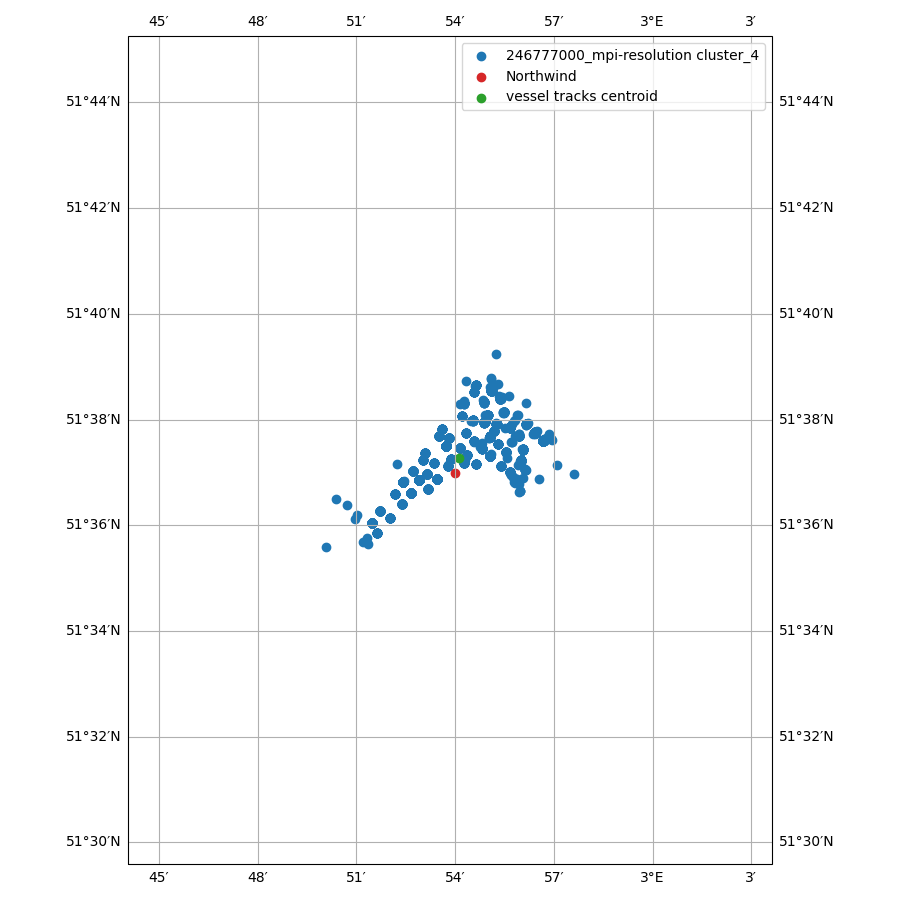

2.9020094743970923 51.62111845391476


<IPython.core.display.Javascript object>


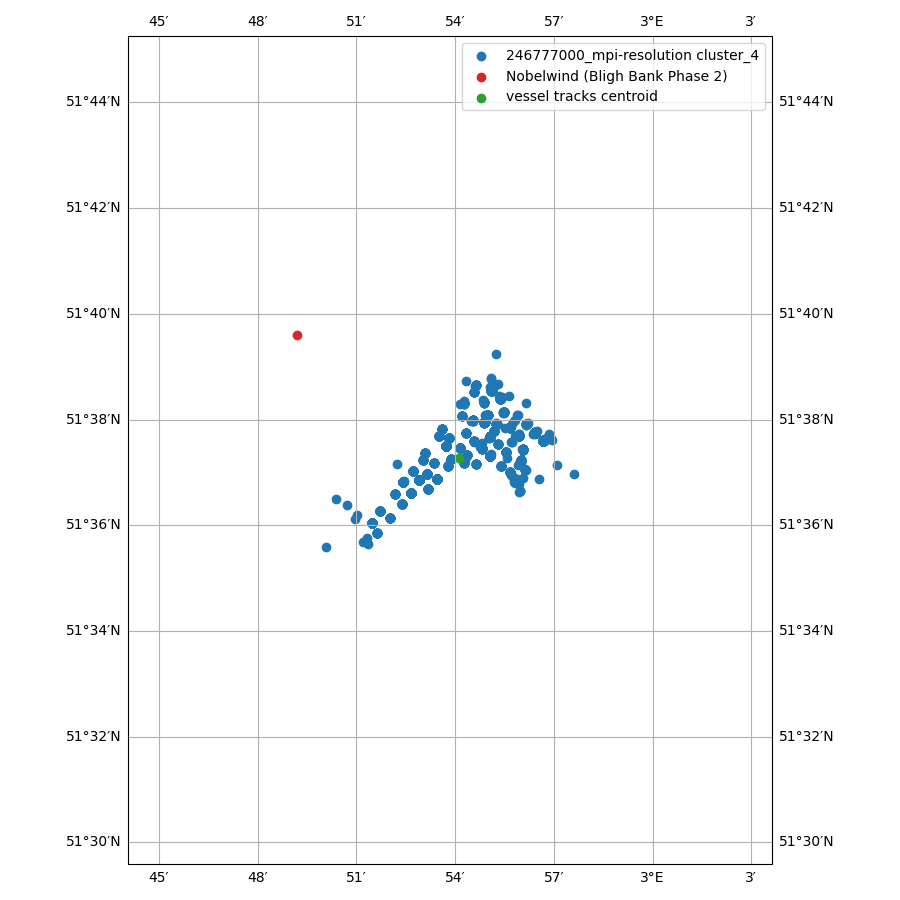

2.9020094743970923 51.62111845391476


<IPython.core.display.Javascript object>


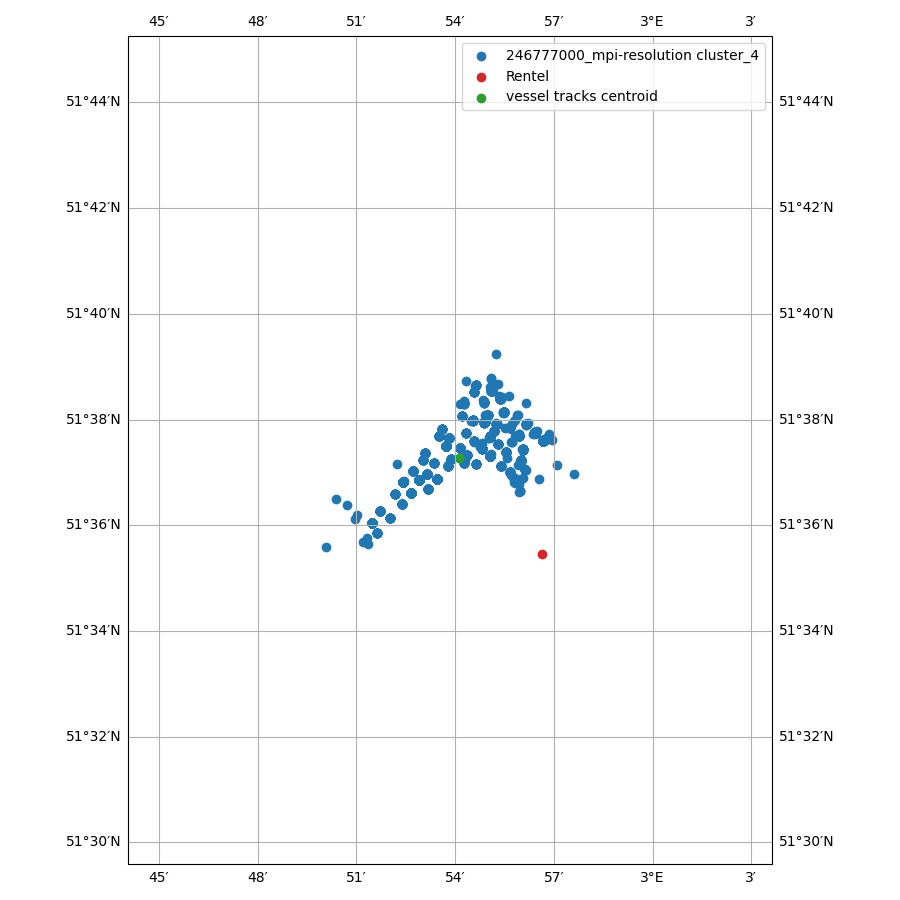

2.9020094743970923 51.62111845391476


<IPython.core.display.Javascript object>


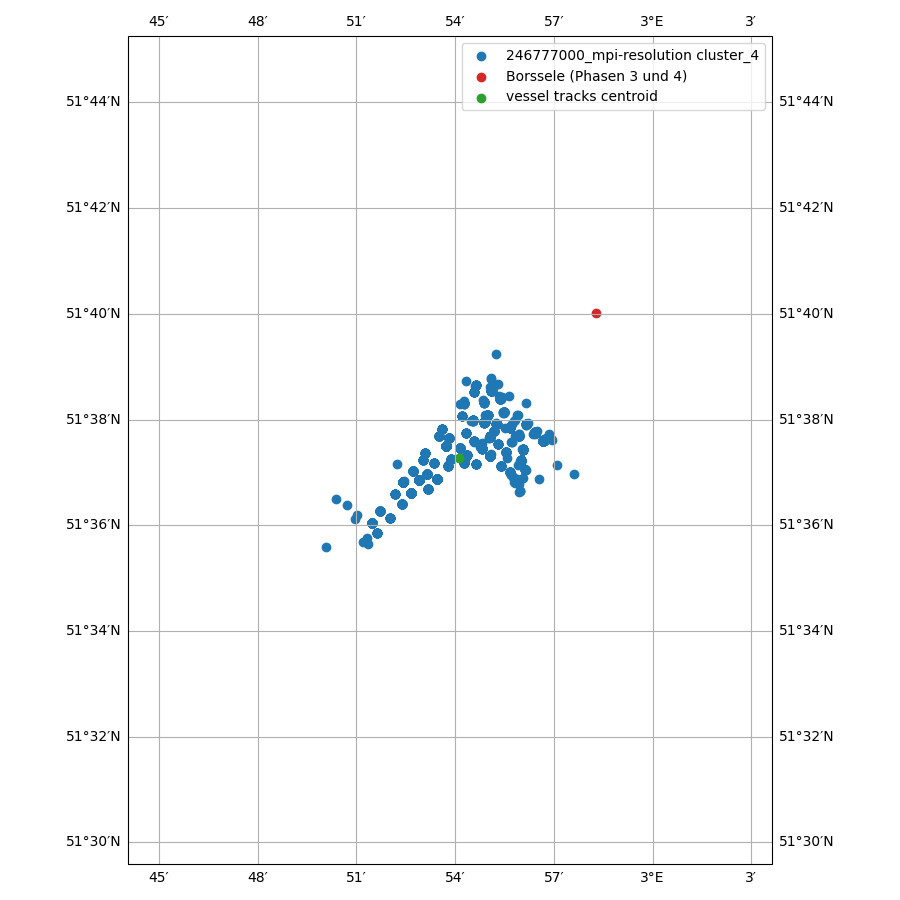

2.9020094743970923 51.62111845391476


<IPython.core.display.Javascript object>


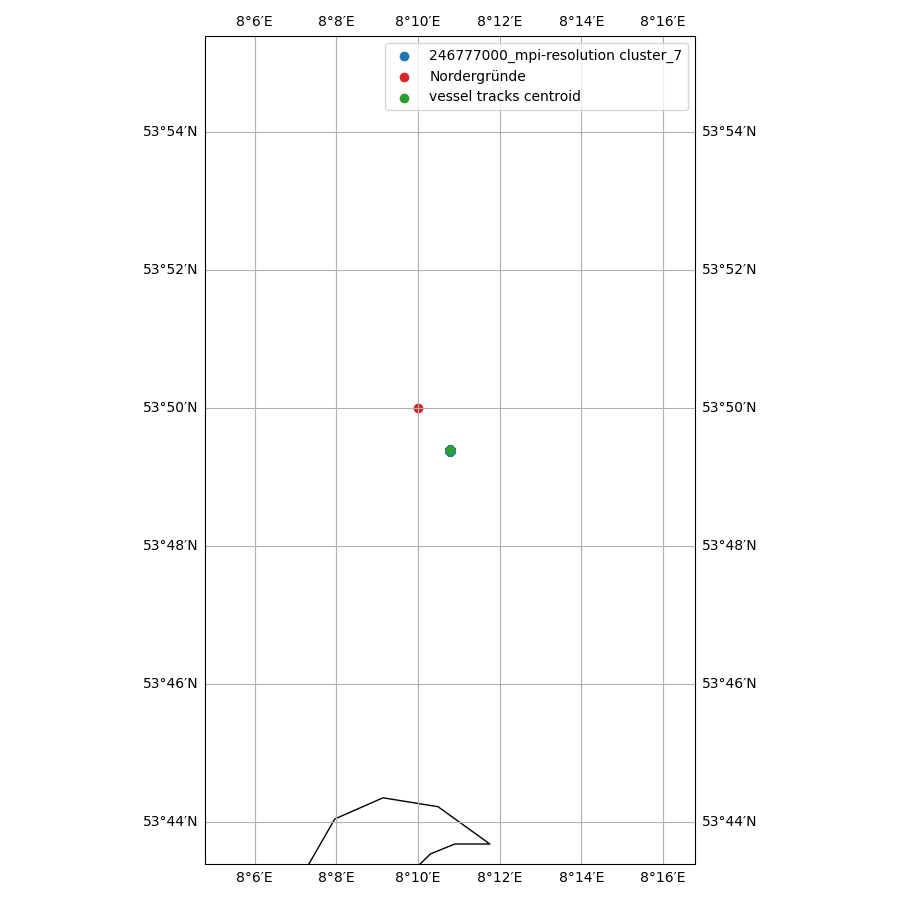

8.179698293137255 53.82315147058823


<IPython.core.display.Javascript object>


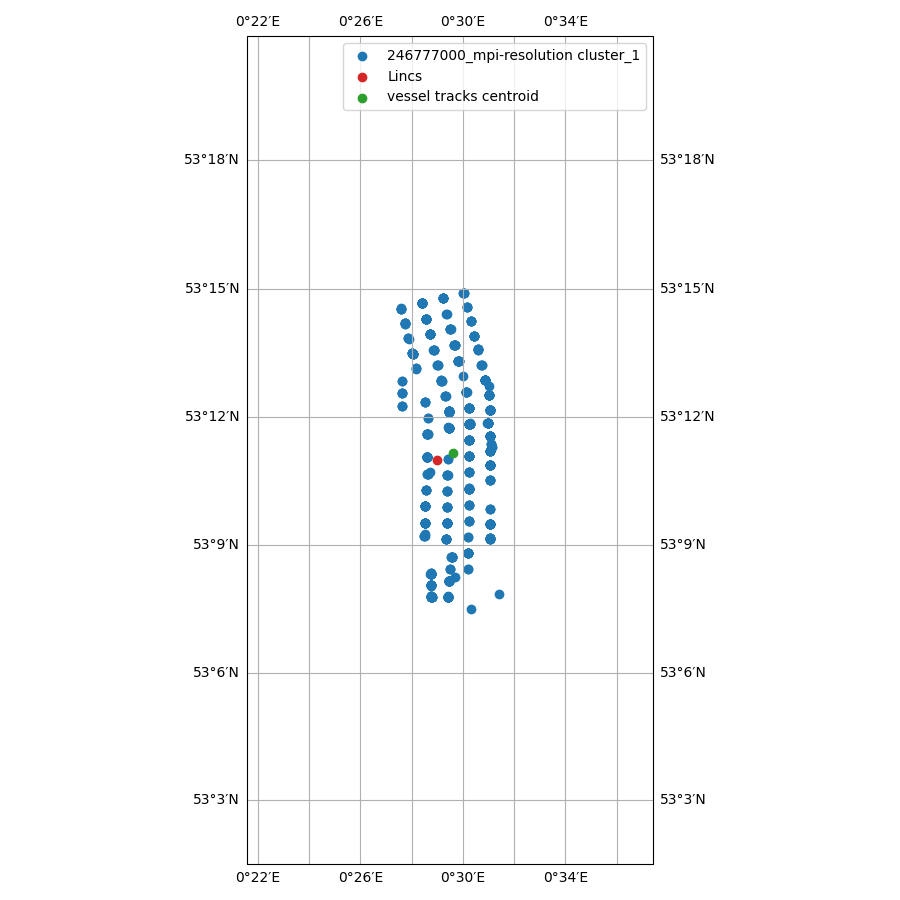

0.4932723243125905 53.18605778581765


<IPython.core.display.Javascript object>


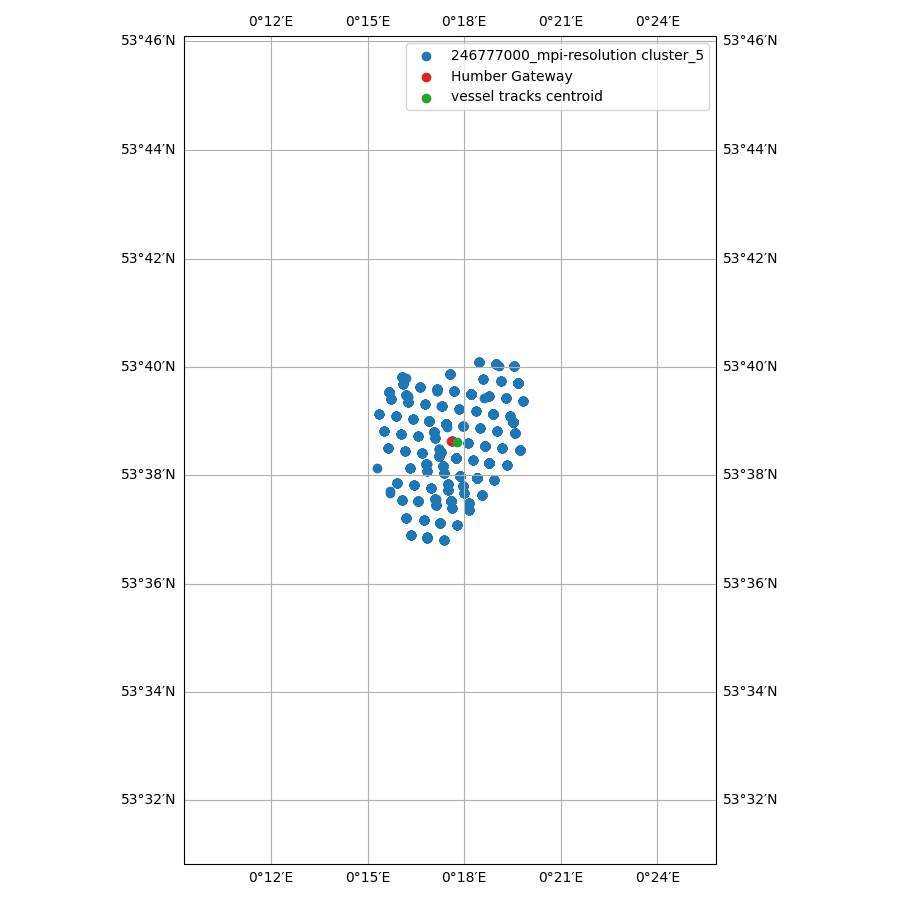

0.29638149697692917 53.6436418005834


<IPython.core.display.Javascript object>


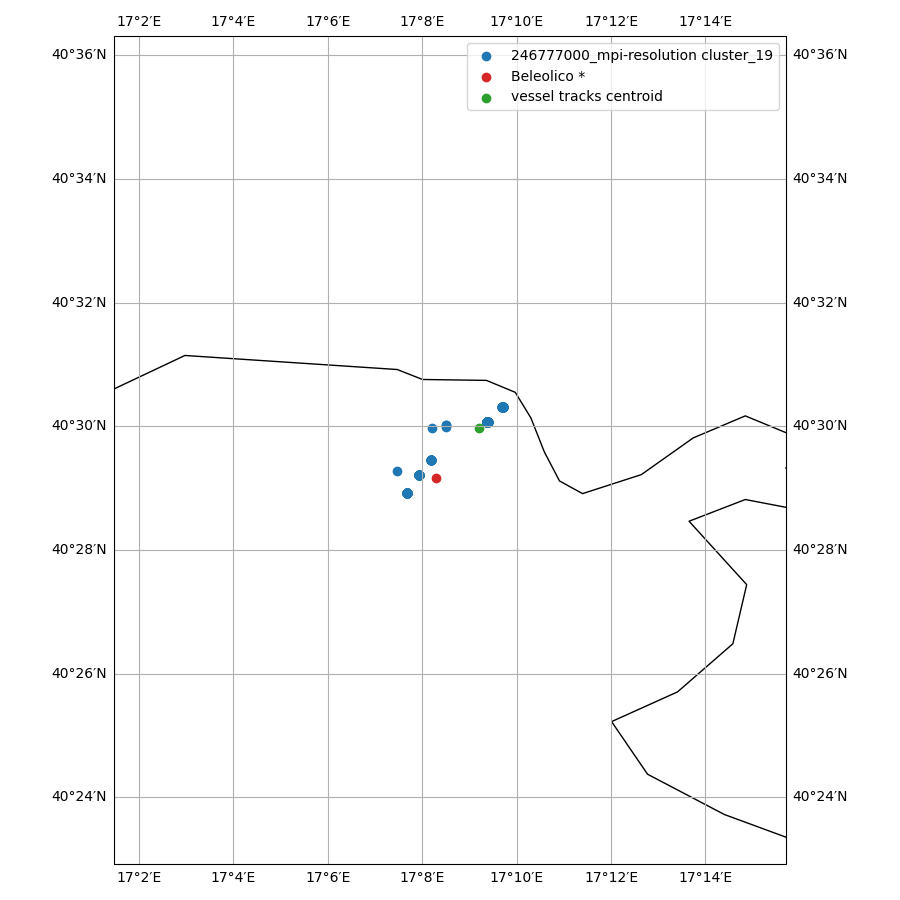

17.153550052117264 40.49959723127036


<IPython.core.display.Javascript object>


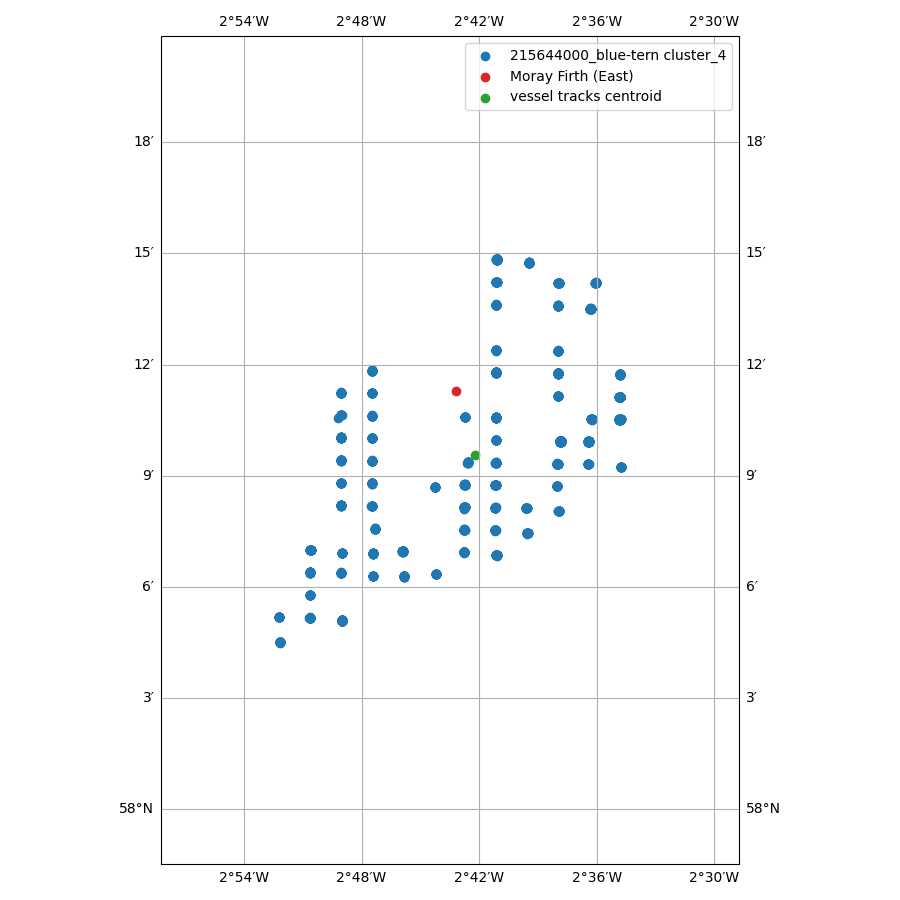

-2.7033957338975085 58.15919898918664


<IPython.core.display.Javascript object>


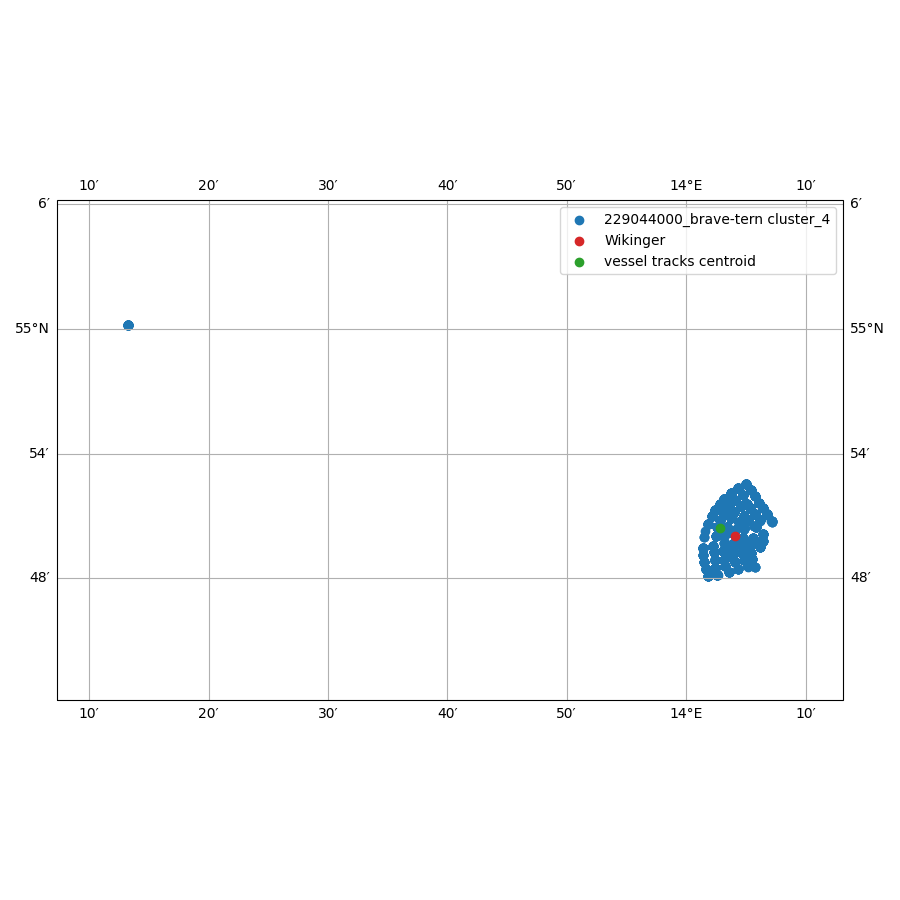

14.047759708580681 54.840417463572585


<IPython.core.display.Javascript object>


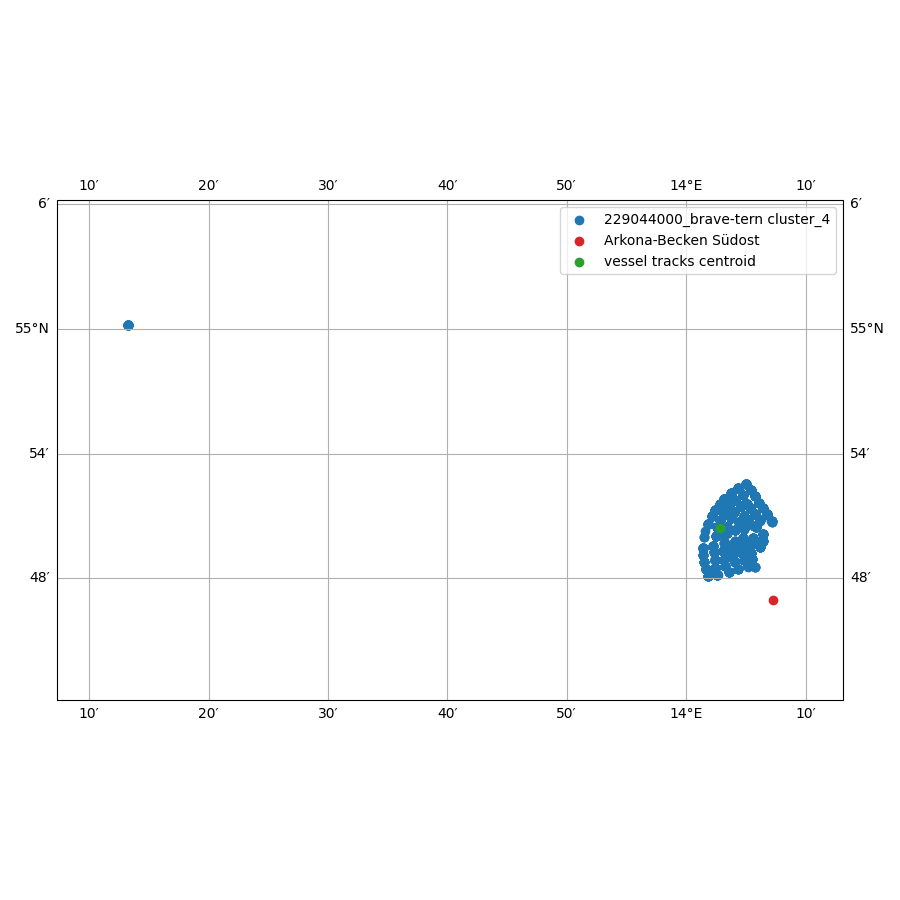

14.047759708580681 54.840417463572585


<IPython.core.display.Javascript object>


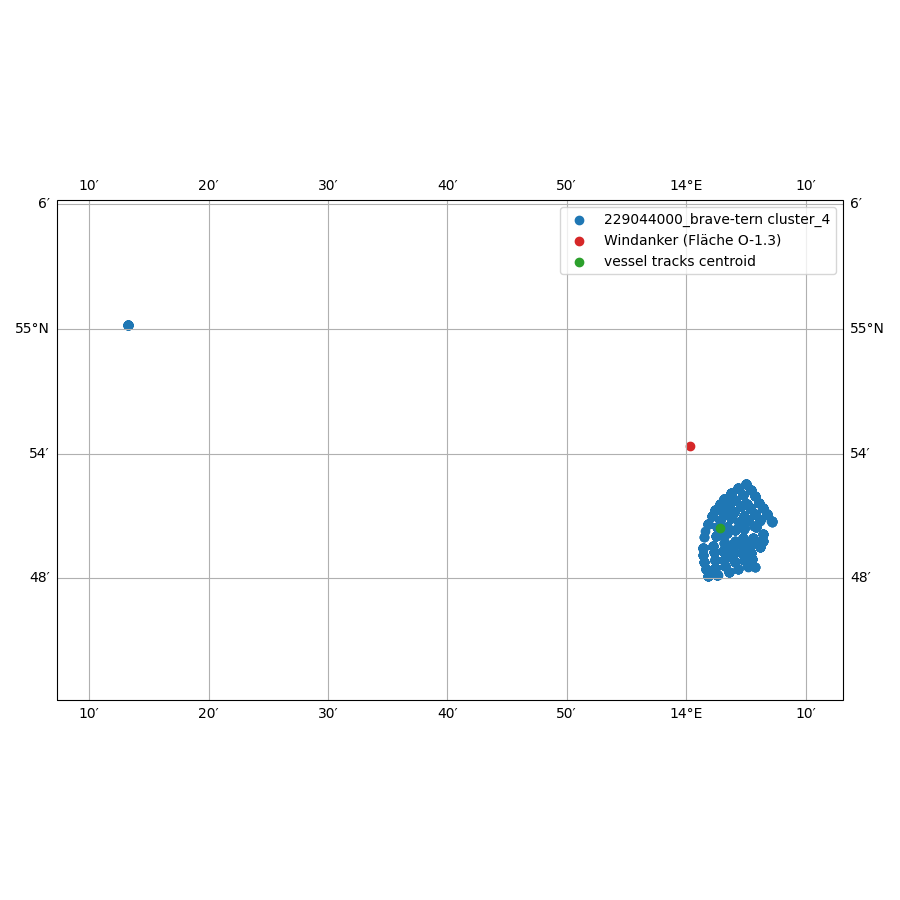

14.047759708580681 54.840417463572585


<IPython.core.display.Javascript object>


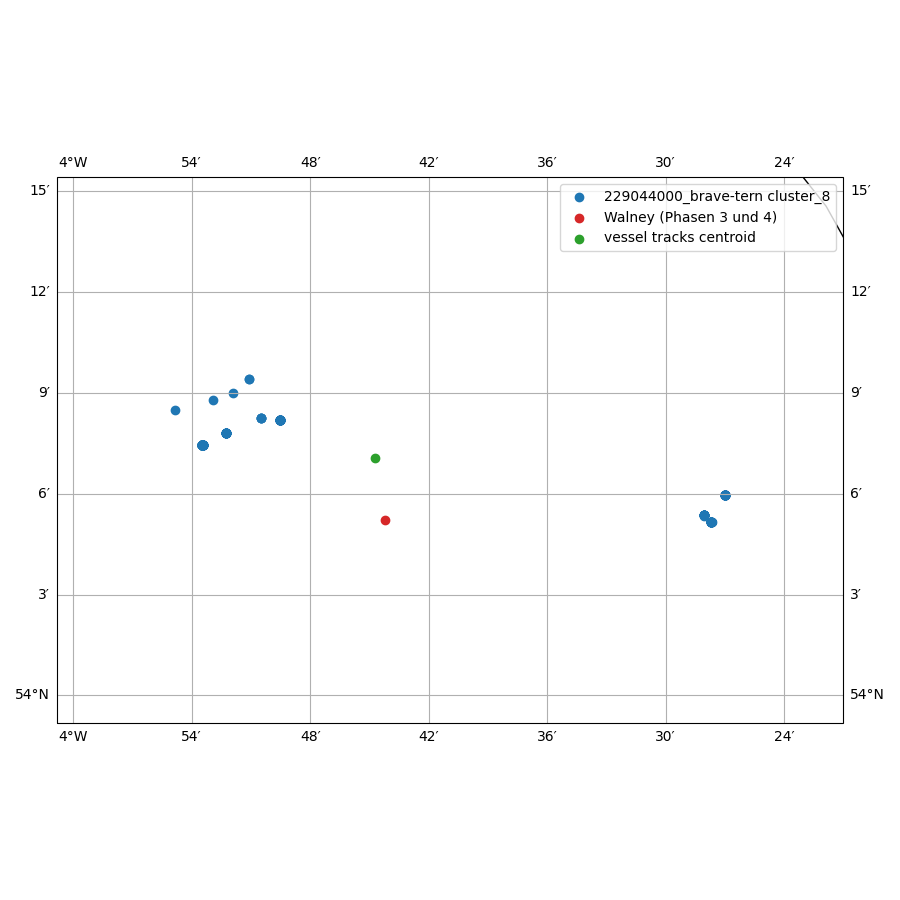

-3.744912893203884 54.11794441747573


<IPython.core.display.Javascript object>


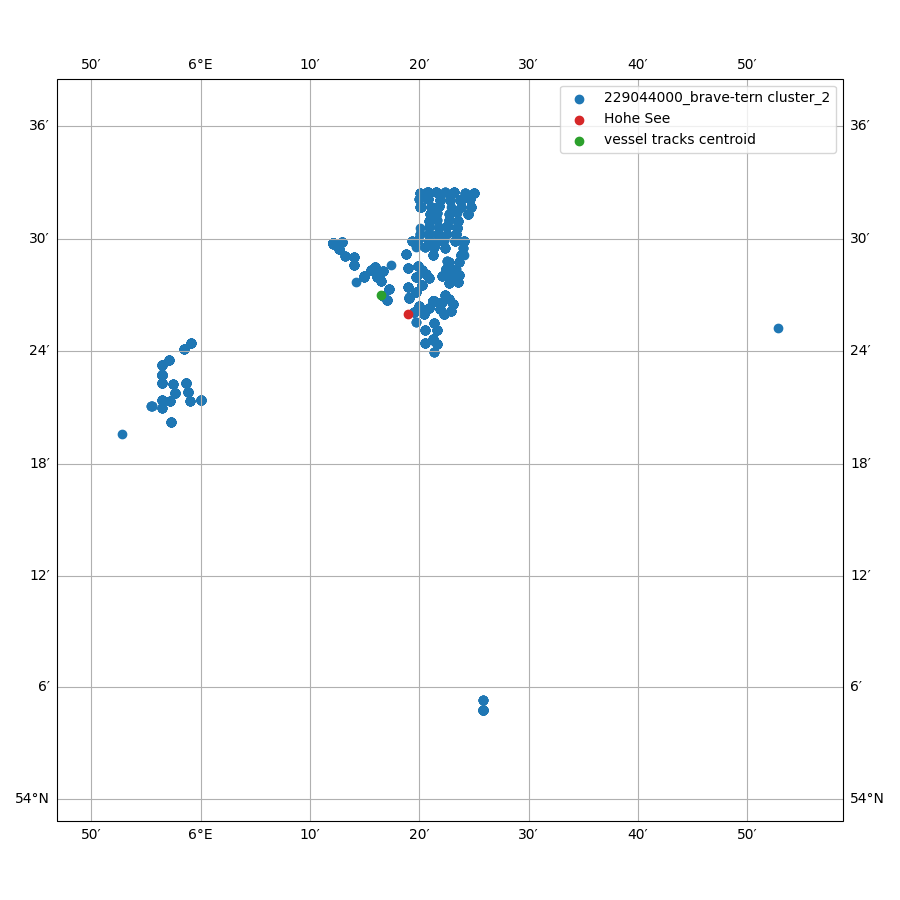

6.275348744549419 54.44996712209303


<IPython.core.display.Javascript object>


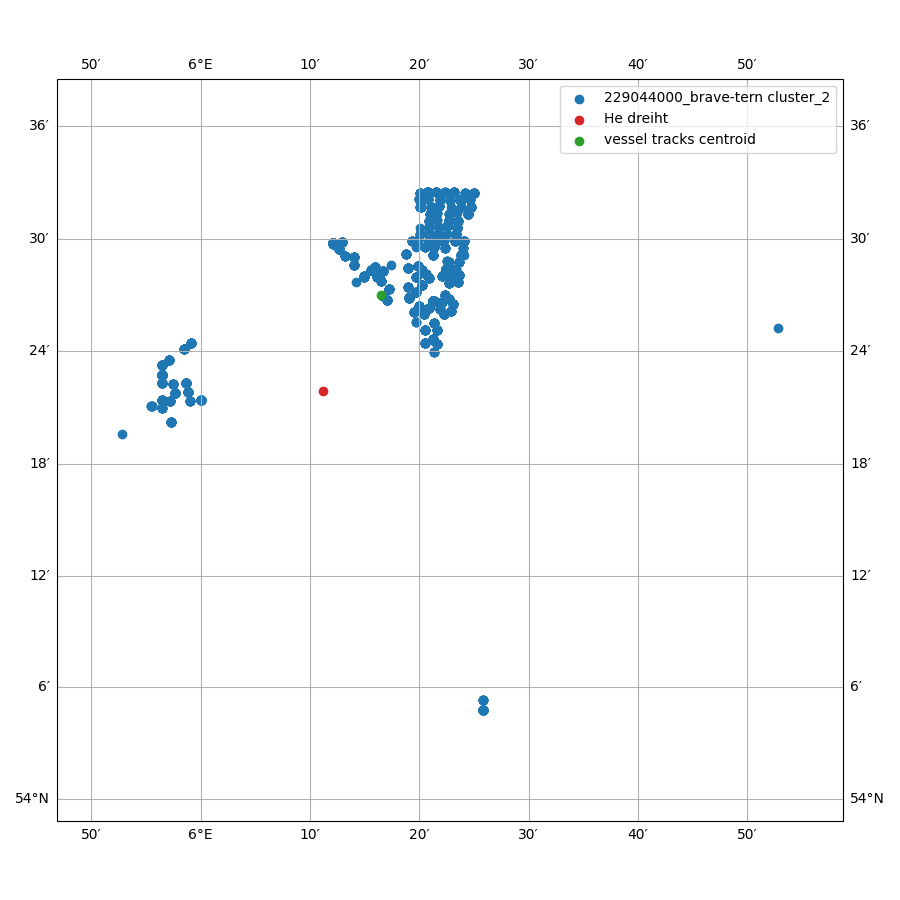

6.275348744549419 54.44996712209303


<IPython.core.display.Javascript object>


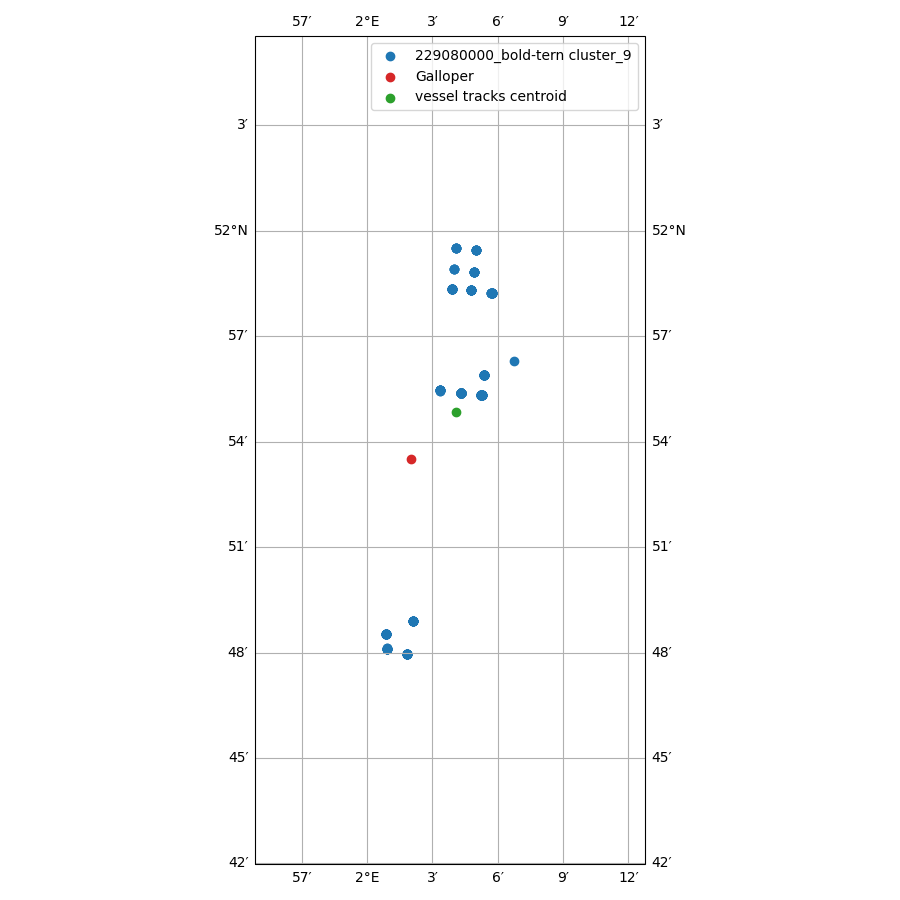

2.067811296829971 51.914191440922195


<IPython.core.display.Javascript object>


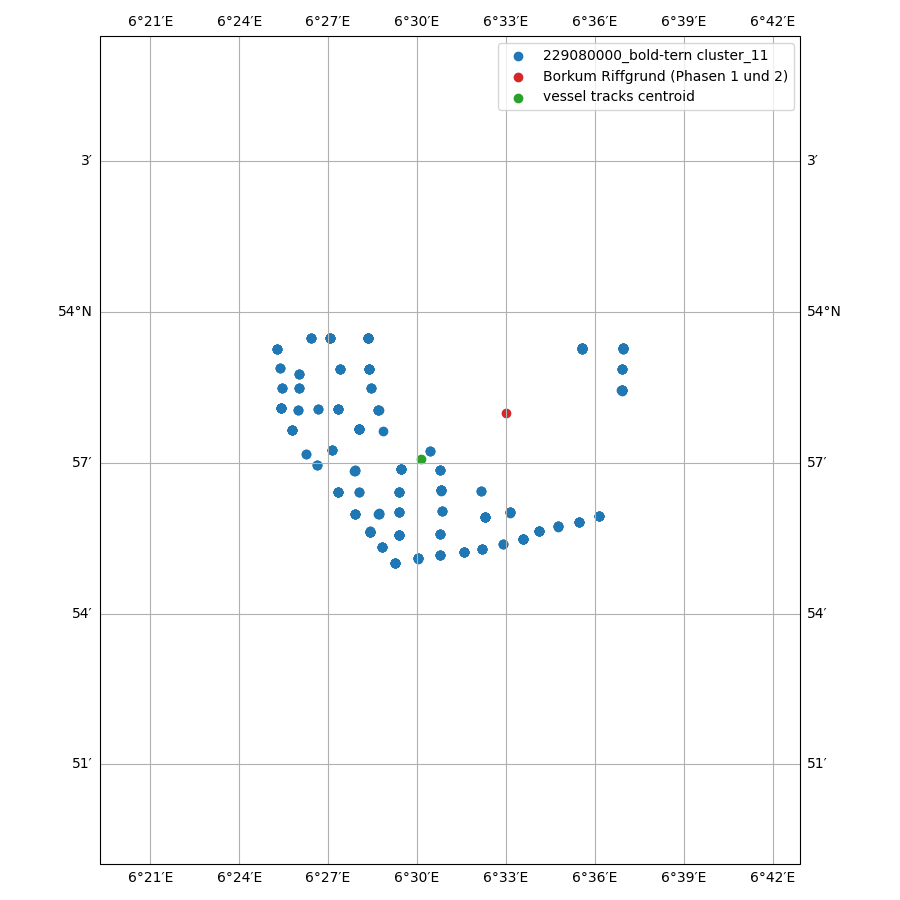

6.5023481145833335 53.951454479166664


<IPython.core.display.Javascript object>


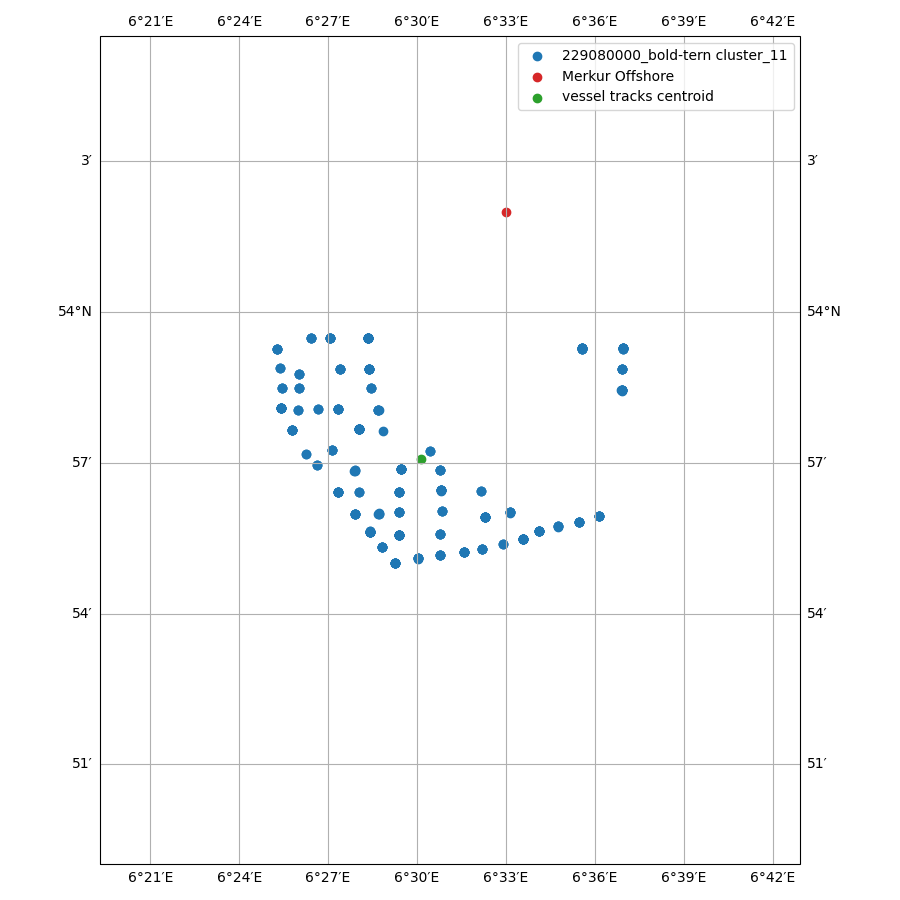

6.5023481145833335 53.951454479166664


<IPython.core.display.Javascript object>


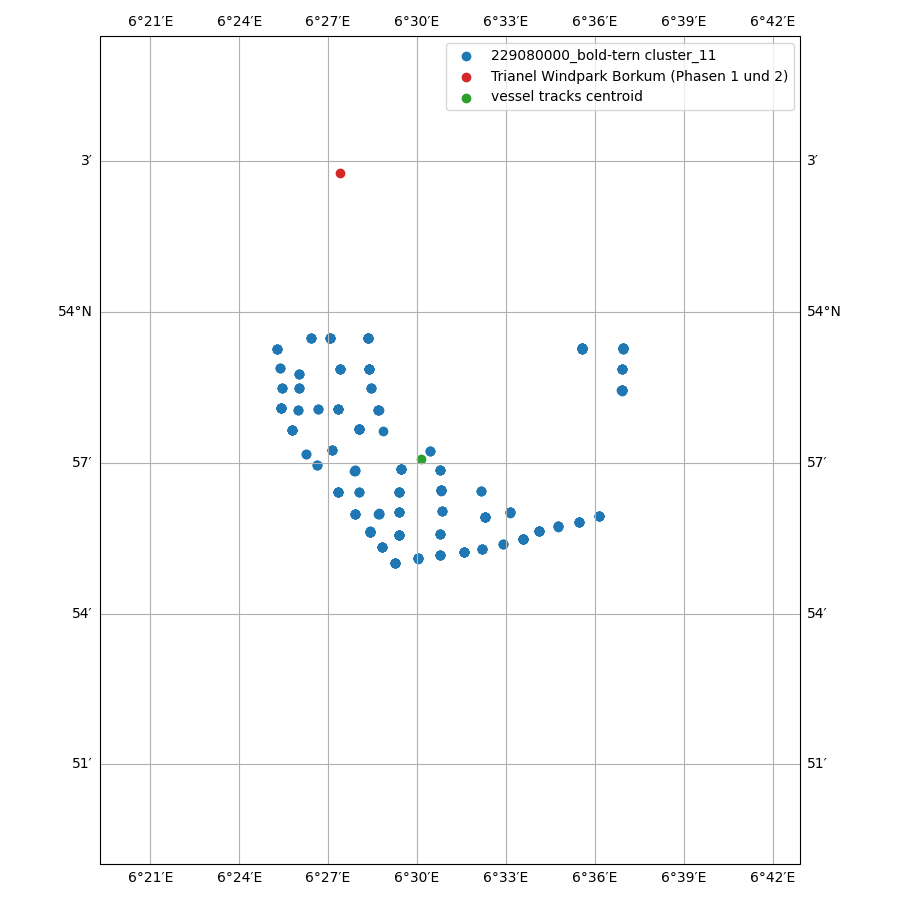

6.5023481145833335 53.951454479166664


<IPython.core.display.Javascript object>


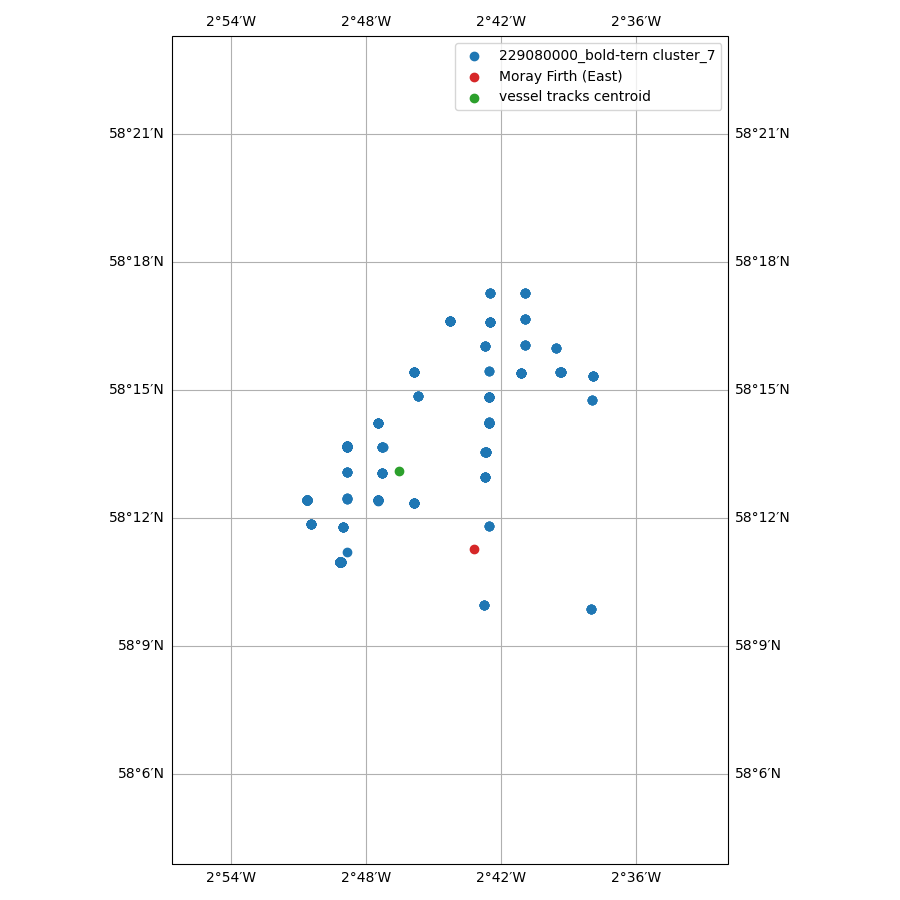

-2.7758492577696527 58.21849329067643


/tmp/ipykernel_403011/2406122249.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=figsize)


<IPython.core.display.Javascript object>


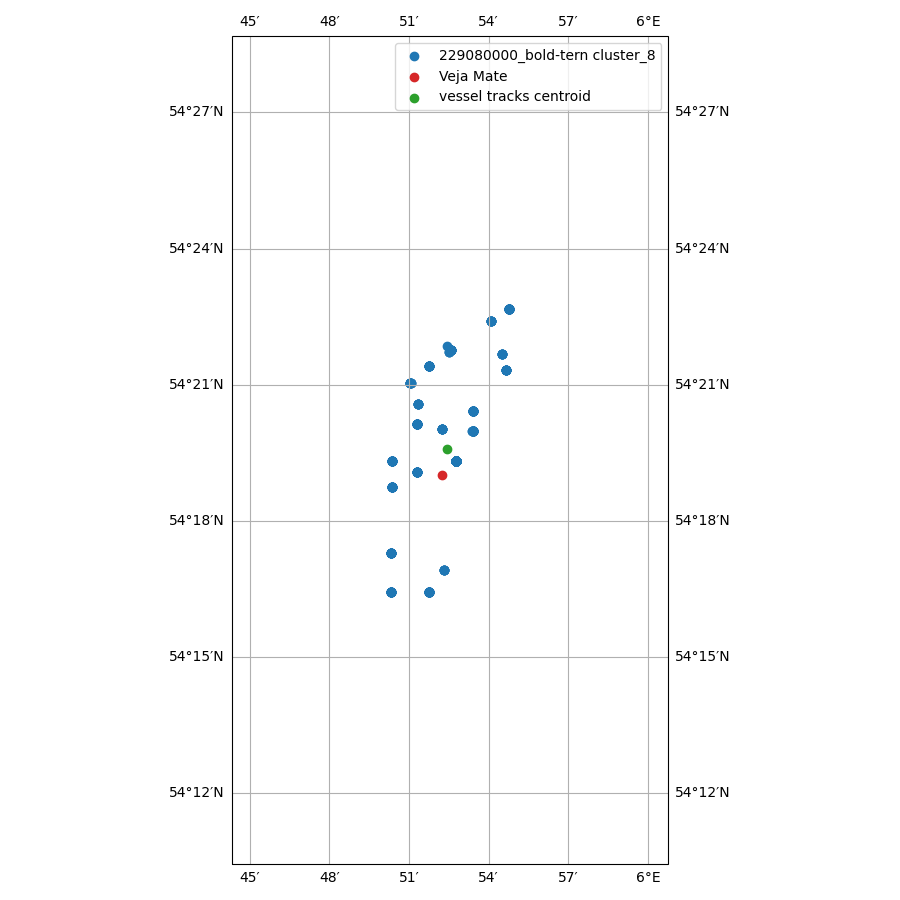

5.873987153061225 54.326712431972794


<IPython.core.display.Javascript object>


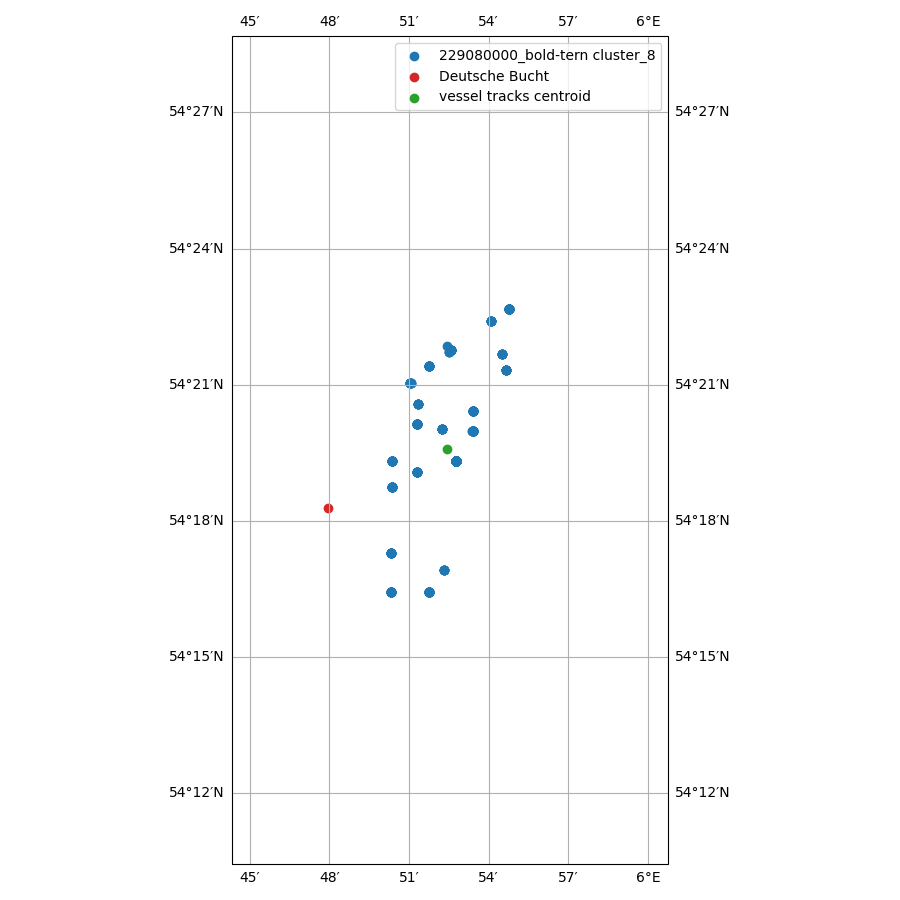

5.873987153061225 54.326712431972794


<IPython.core.display.Javascript object>


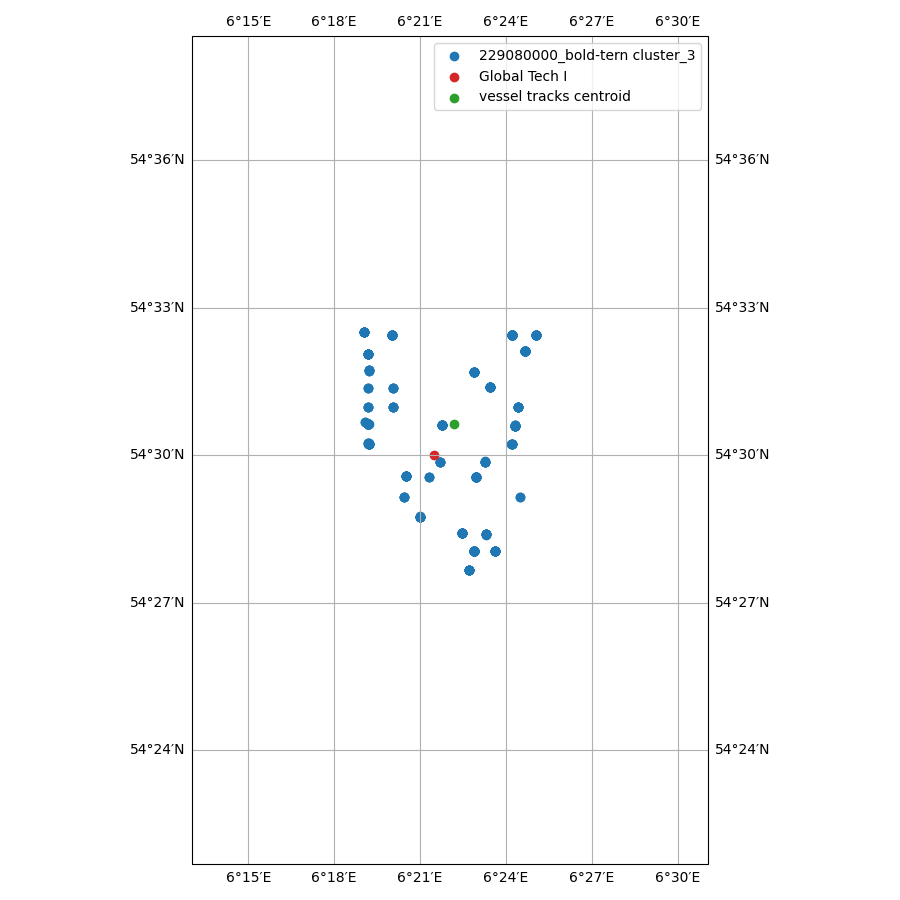

6.369831538310413 54.51064332023575


<IPython.core.display.Javascript object>


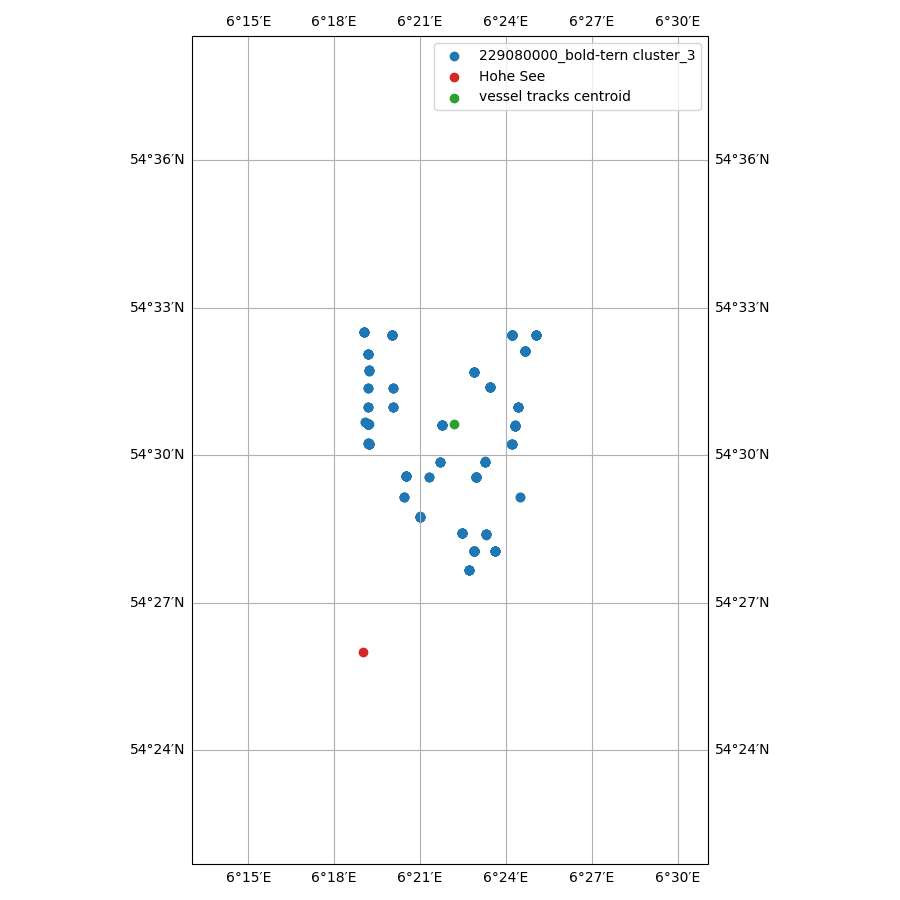

6.369831538310413 54.51064332023575


<IPython.core.display.Javascript object>


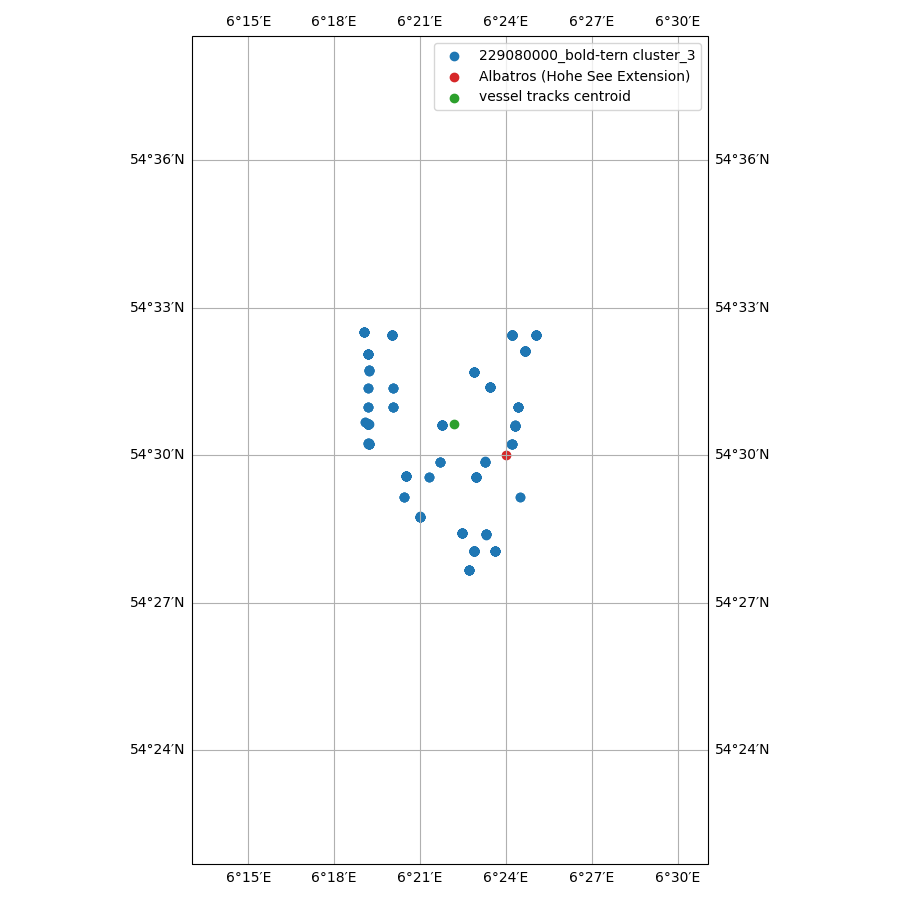

6.369831538310413 54.51064332023575


<IPython.core.display.Javascript object>


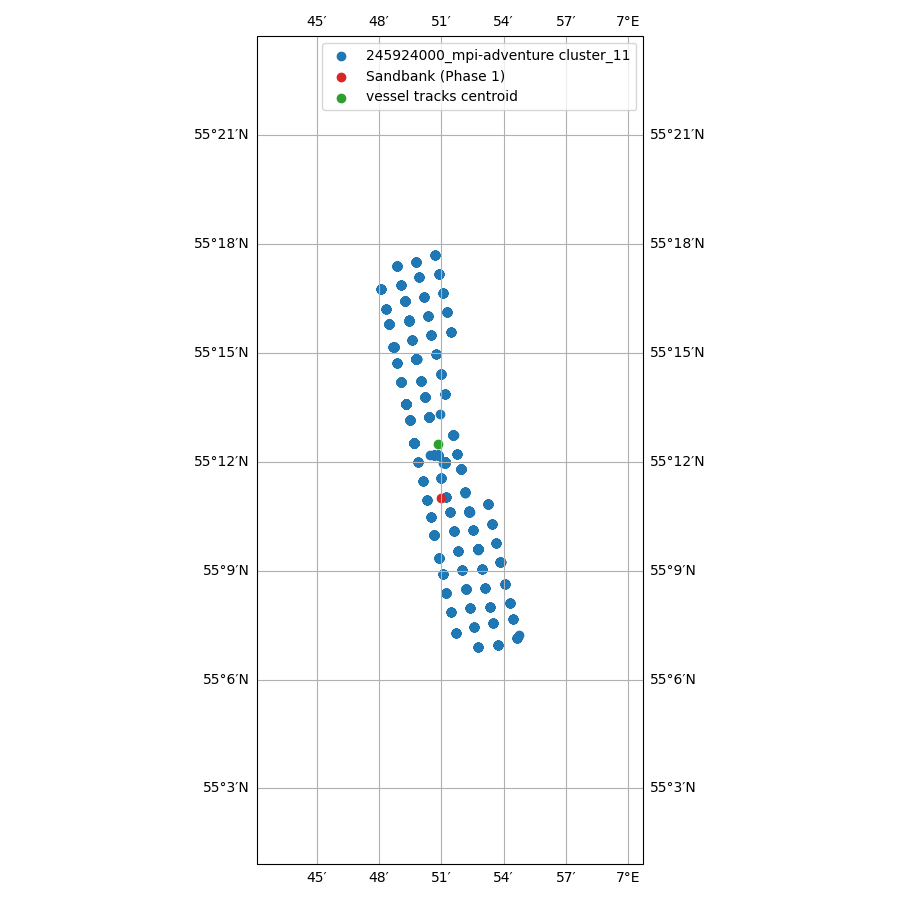

6.847074397830019 55.208180765521405


<IPython.core.display.Javascript object>


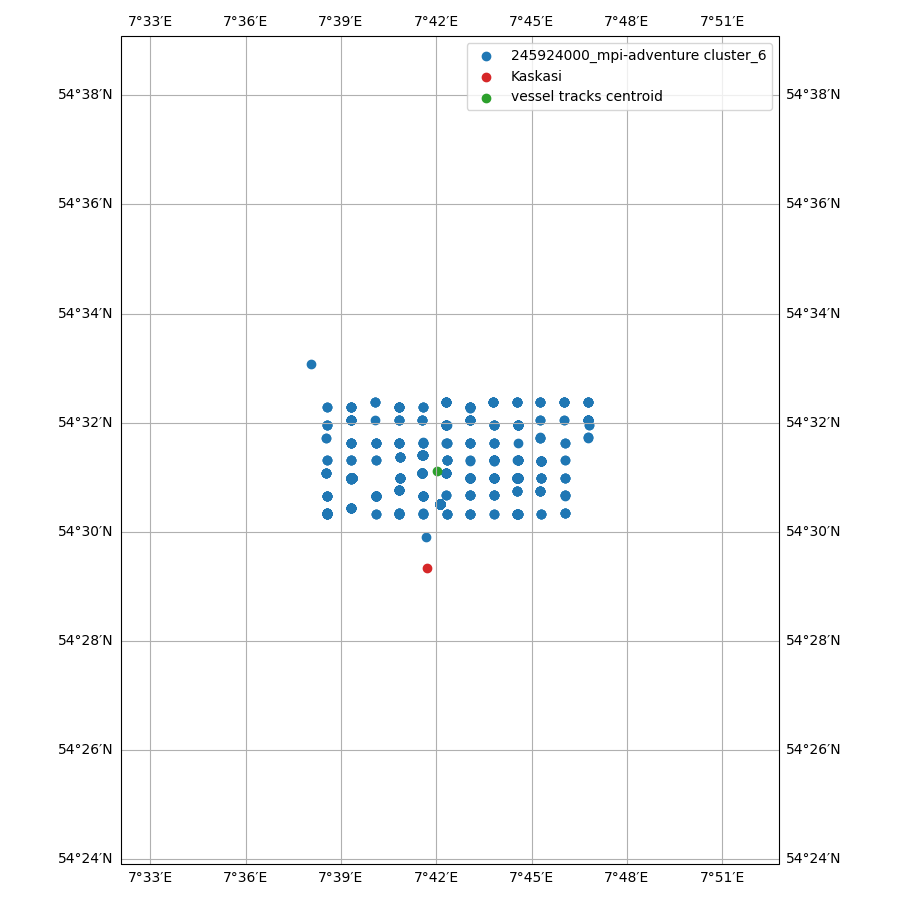

7.700167464935065 54.51864


<IPython.core.display.Javascript object>


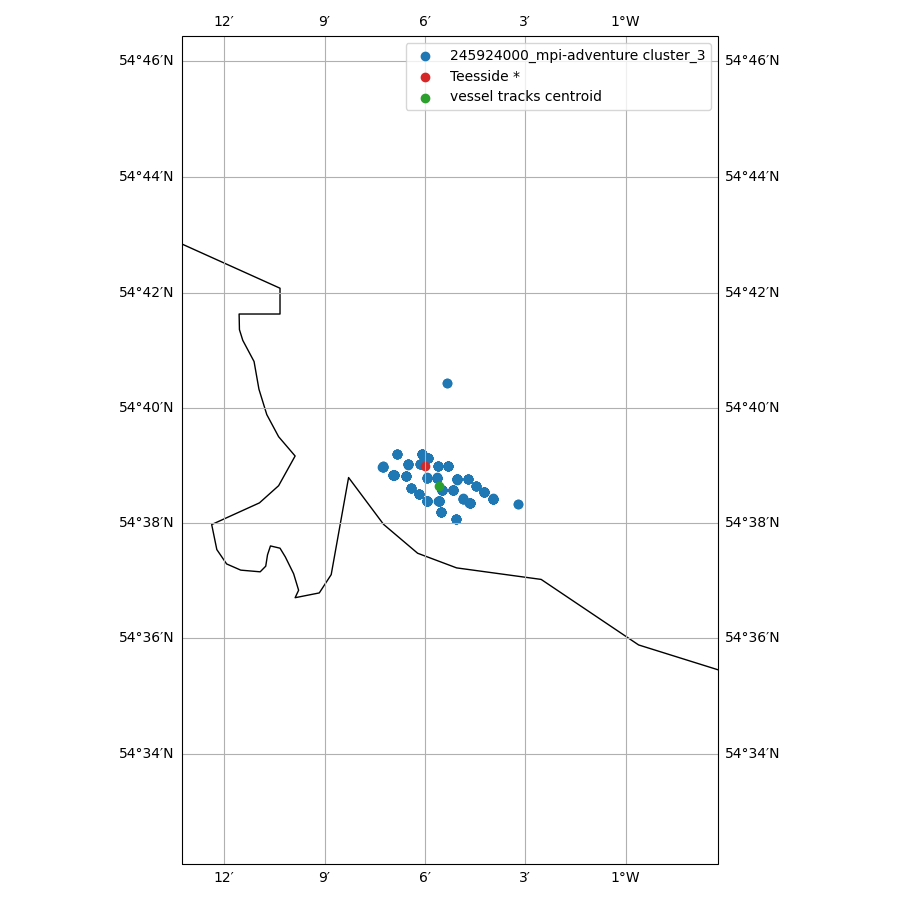

-1.093048410798122 54.644194295774646


<IPython.core.display.Javascript object>


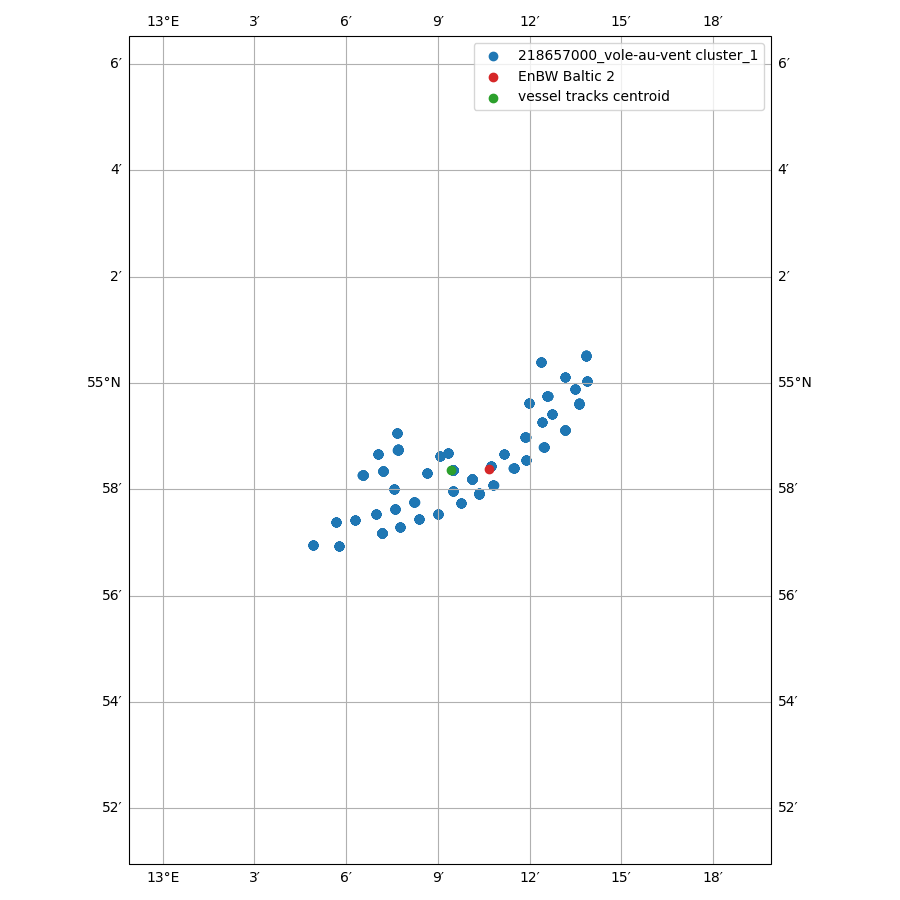

13.15688964661654 54.97279441353383


<IPython.core.display.Javascript object>


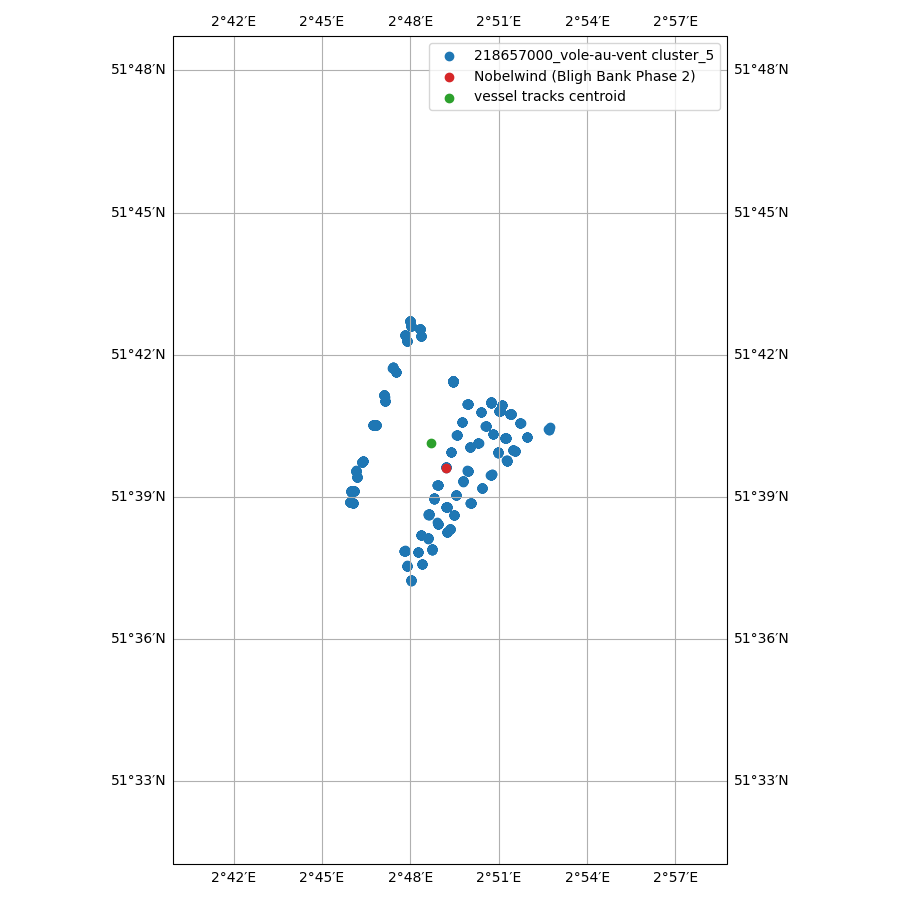

2.811856316266425 51.66888570457635


<IPython.core.display.Javascript object>


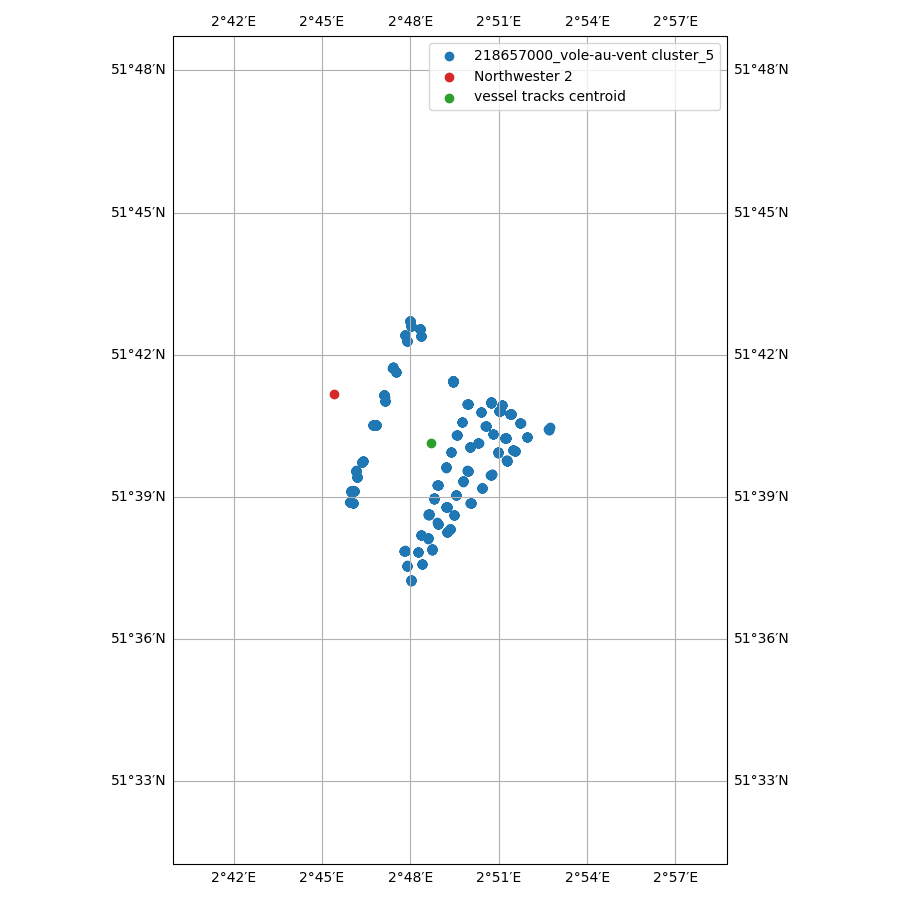

2.811856316266425 51.66888570457635


<IPython.core.display.Javascript object>


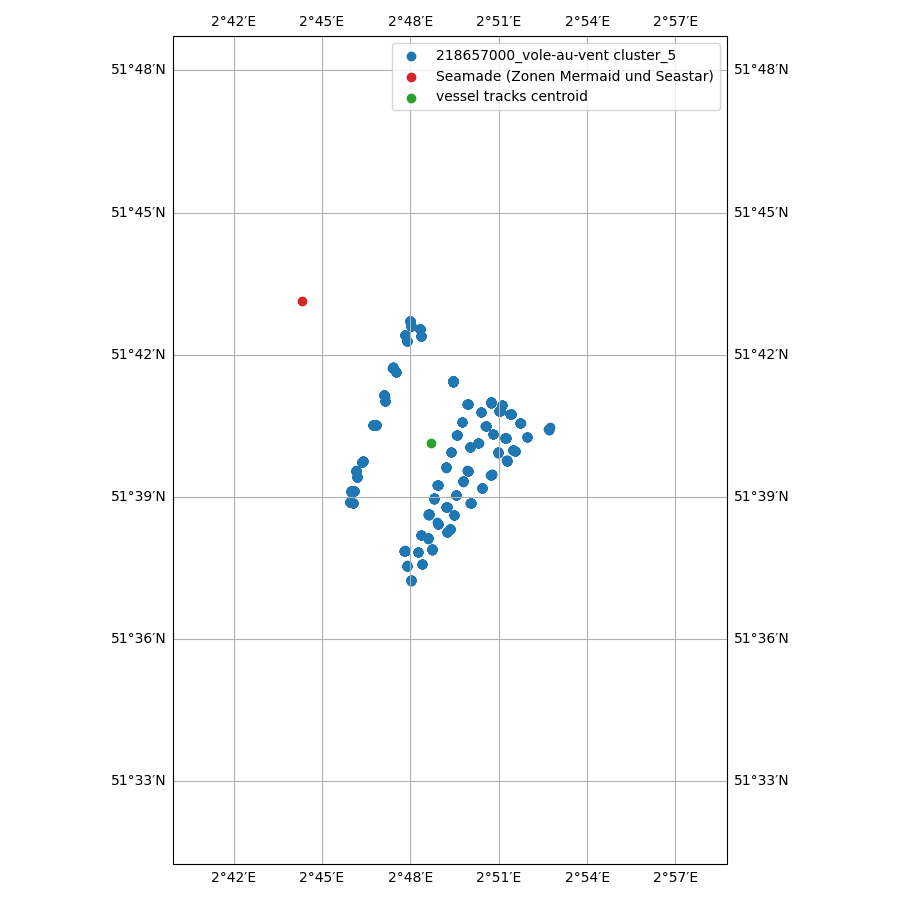

2.811856316266425 51.66888570457635


<IPython.core.display.Javascript object>


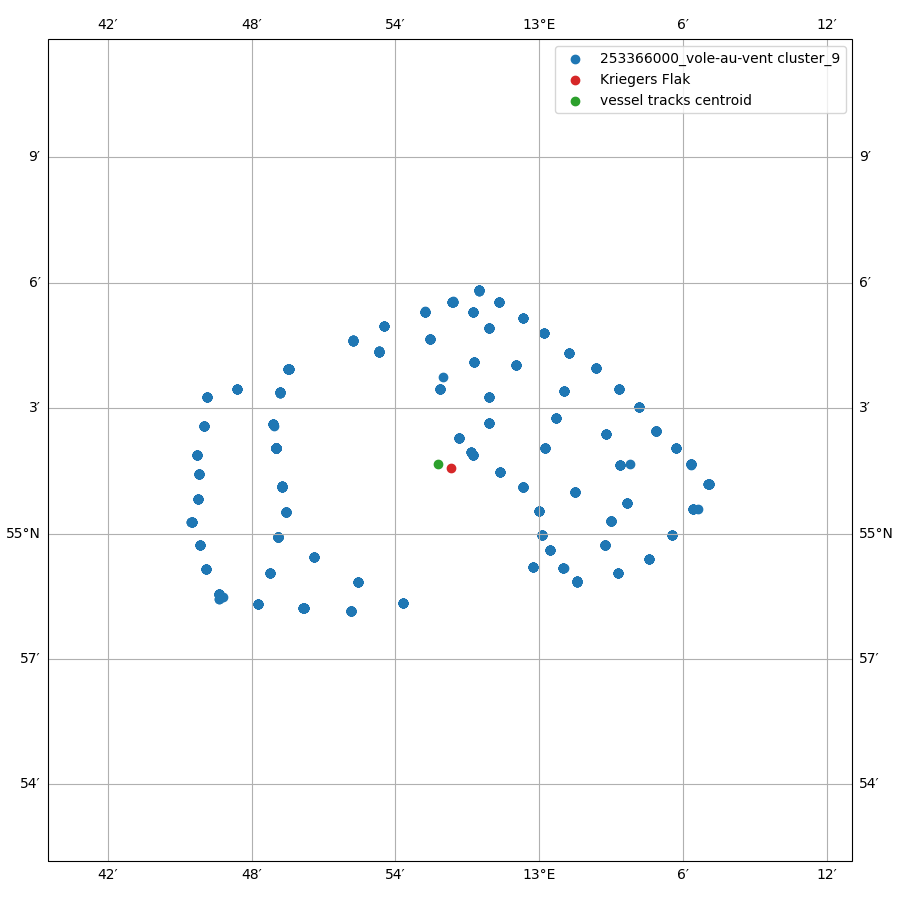

12.929760398335315 55.0280316765755


<IPython.core.display.Javascript object>


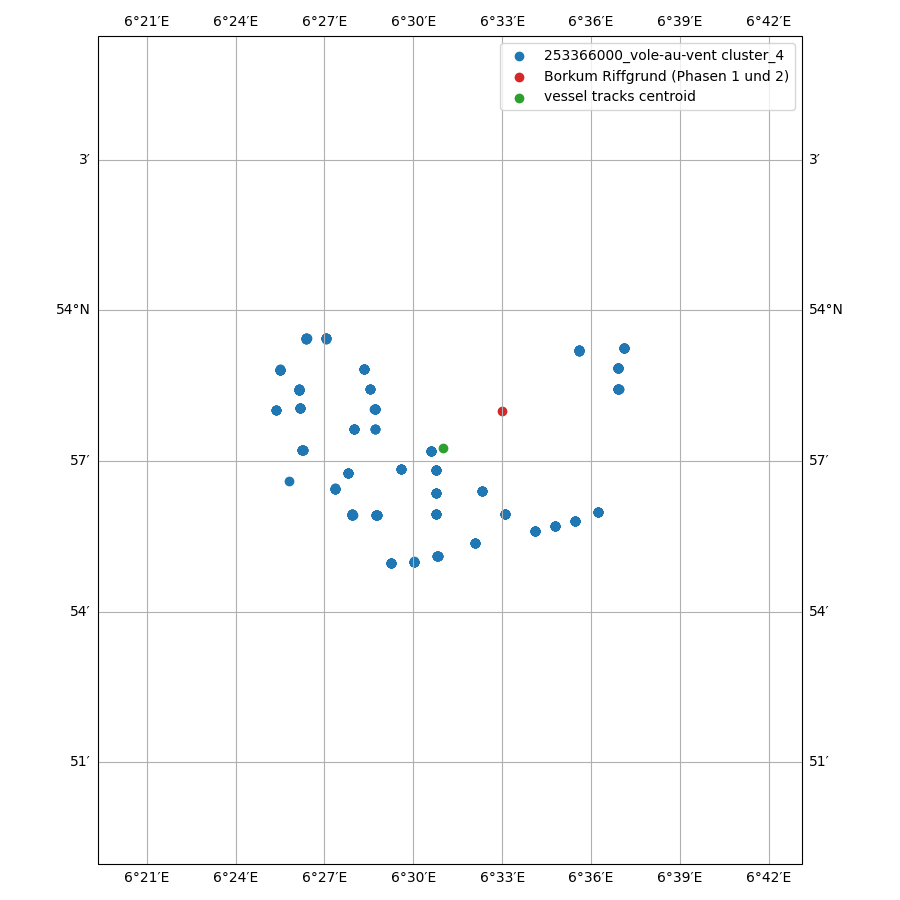

6.516667918560605 53.95420145833334


<IPython.core.display.Javascript object>


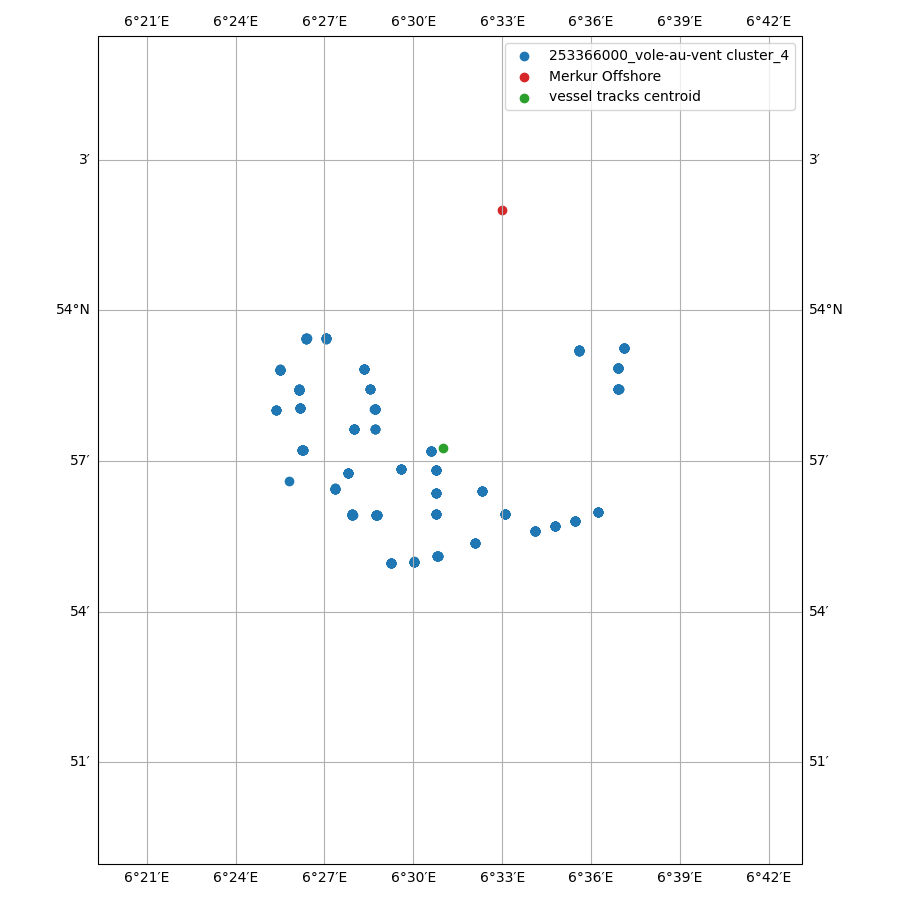

6.516667918560605 53.95420145833334


<IPython.core.display.Javascript object>


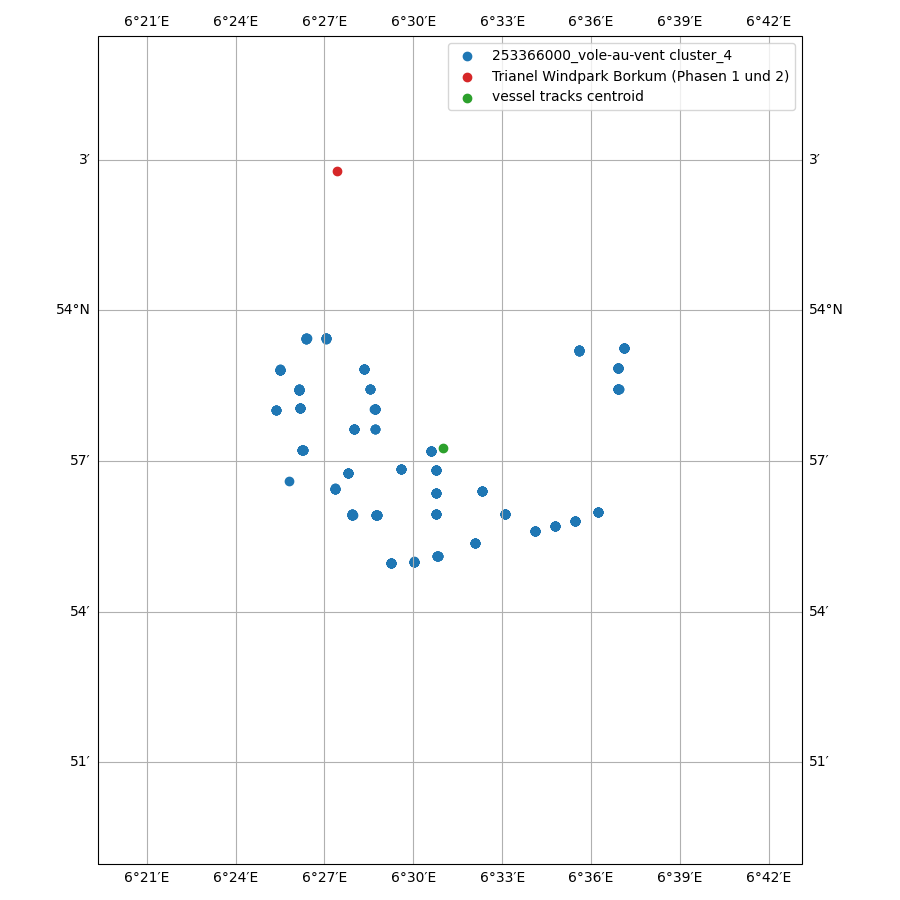

6.516667918560605 53.95420145833334


<IPython.core.display.Javascript object>


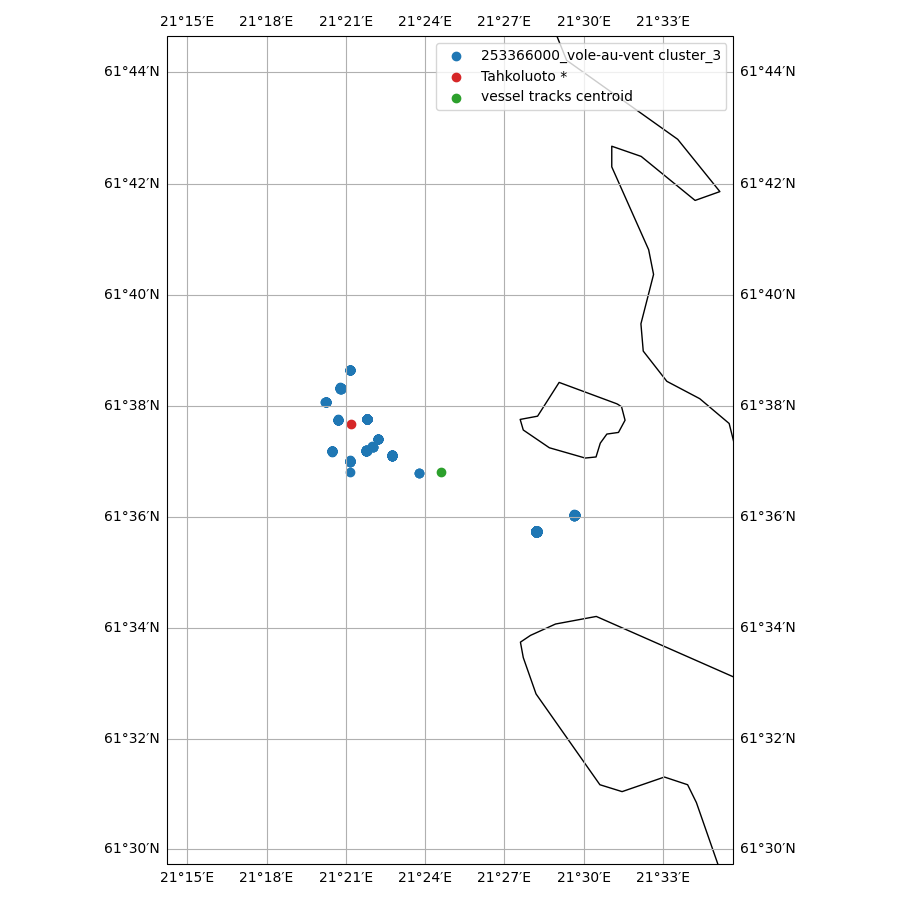

21.410062892030847 61.6134159125964


<IPython.core.display.Javascript object>


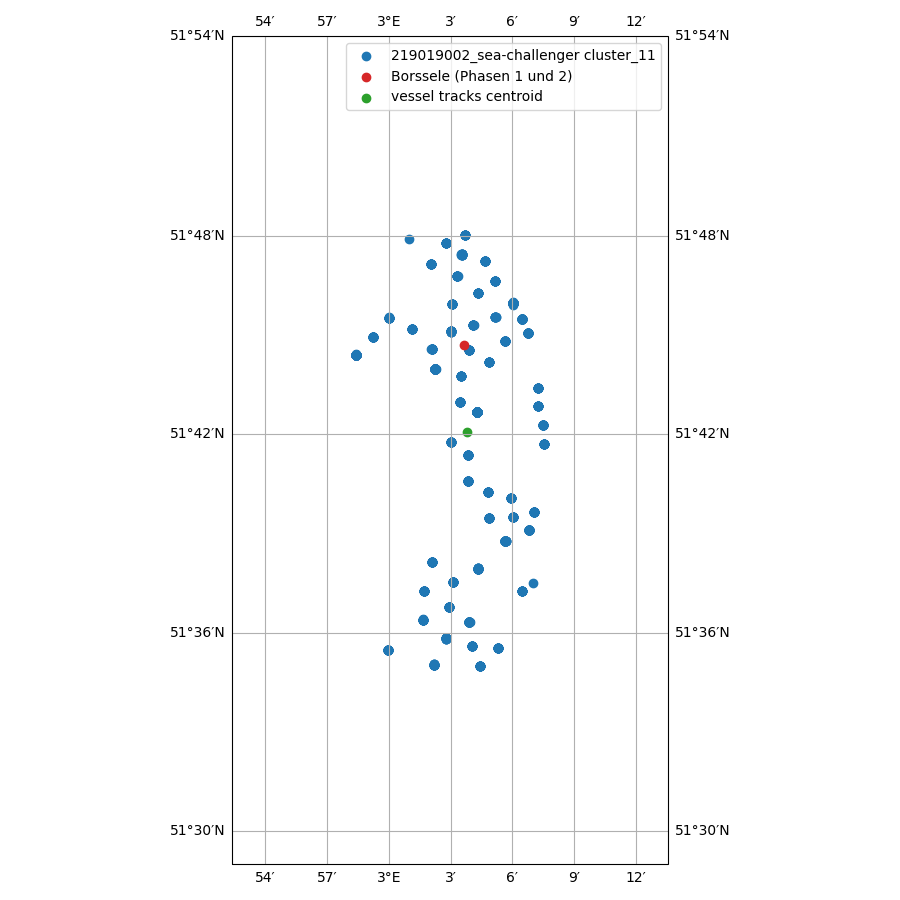

3.063396044126787 51.70114293971411


<IPython.core.display.Javascript object>


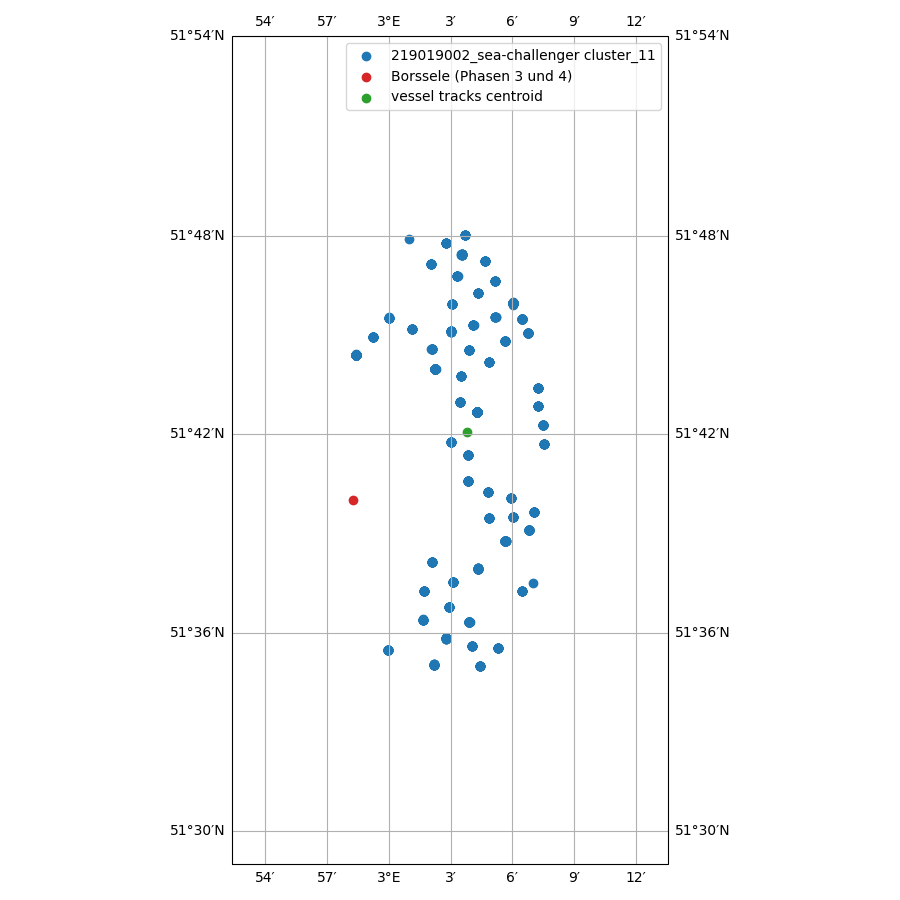

3.063396044126787 51.70114293971411


<IPython.core.display.Javascript object>


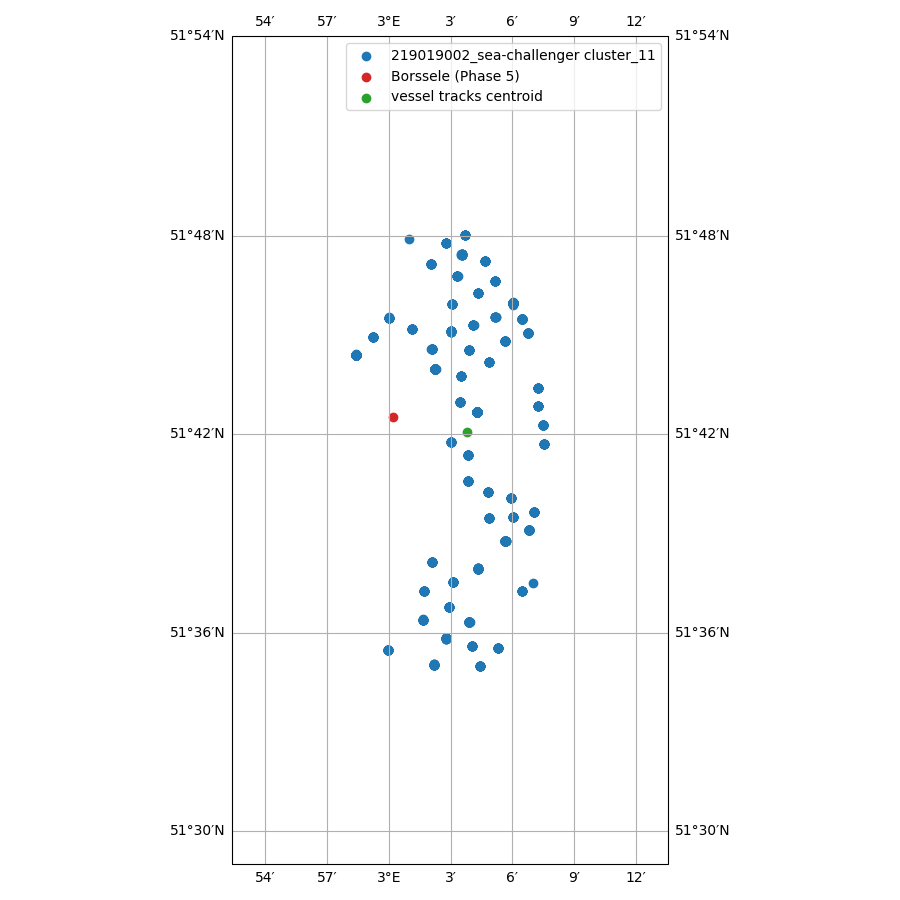

3.063396044126787 51.70114293971411


<IPython.core.display.Javascript object>


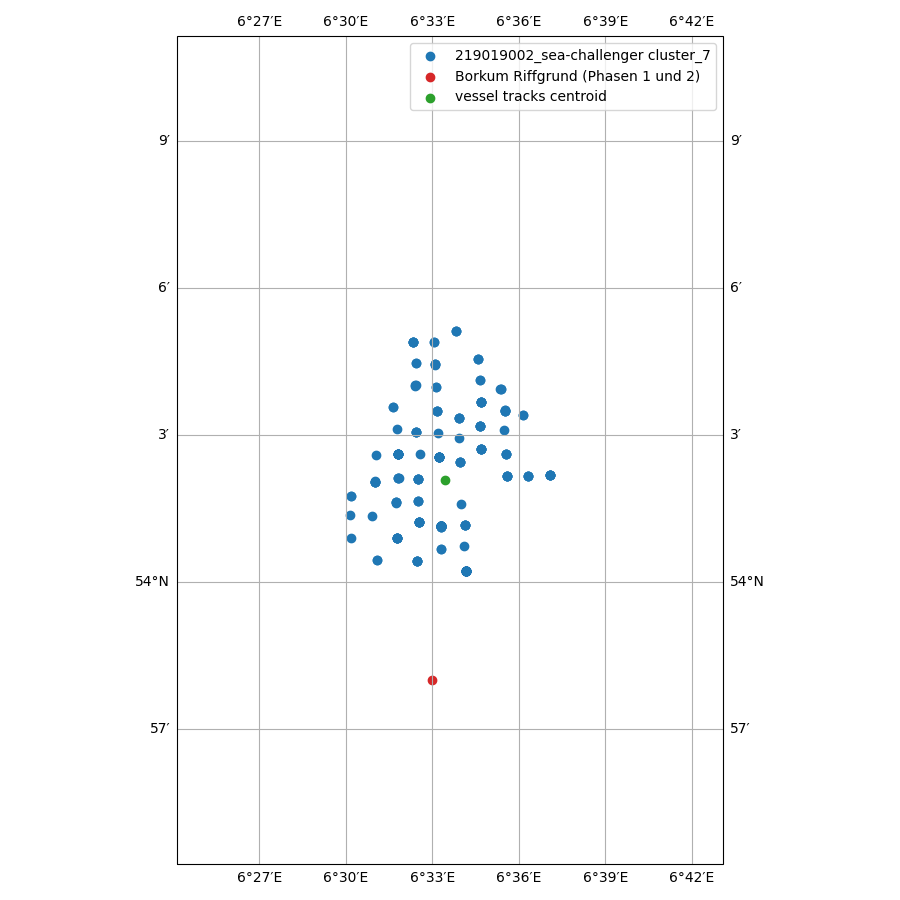

6.557355207171315 54.034739641434264


<IPython.core.display.Javascript object>


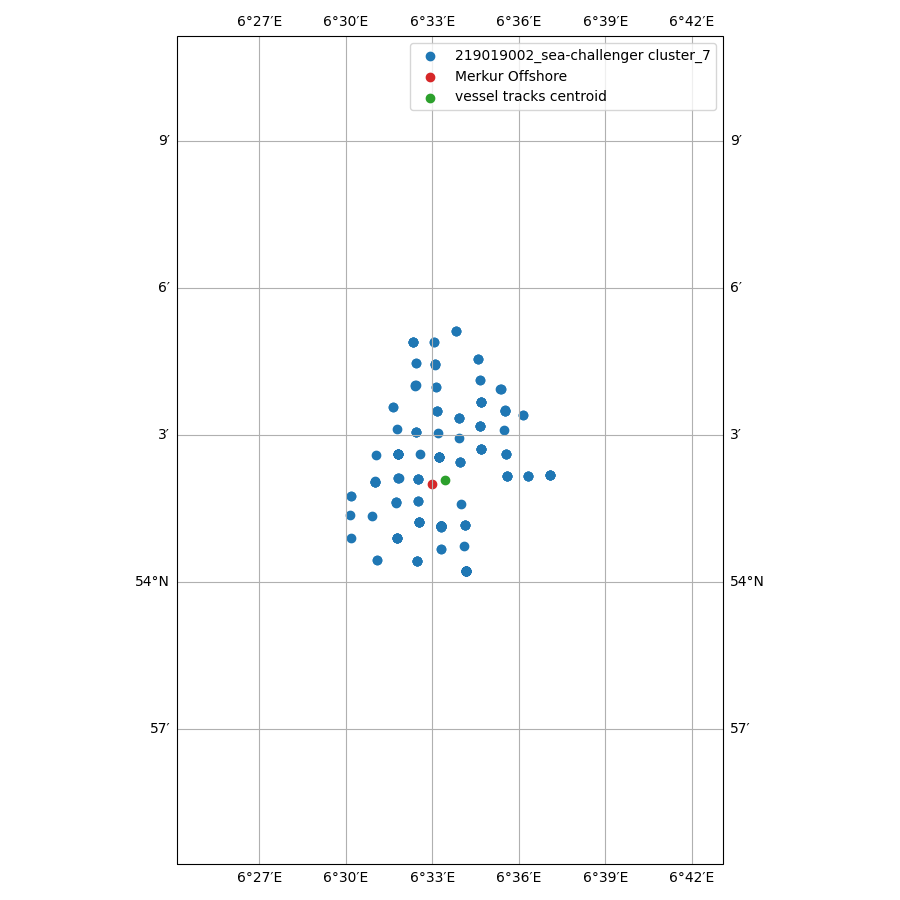

6.557355207171315 54.034739641434264


<IPython.core.display.Javascript object>


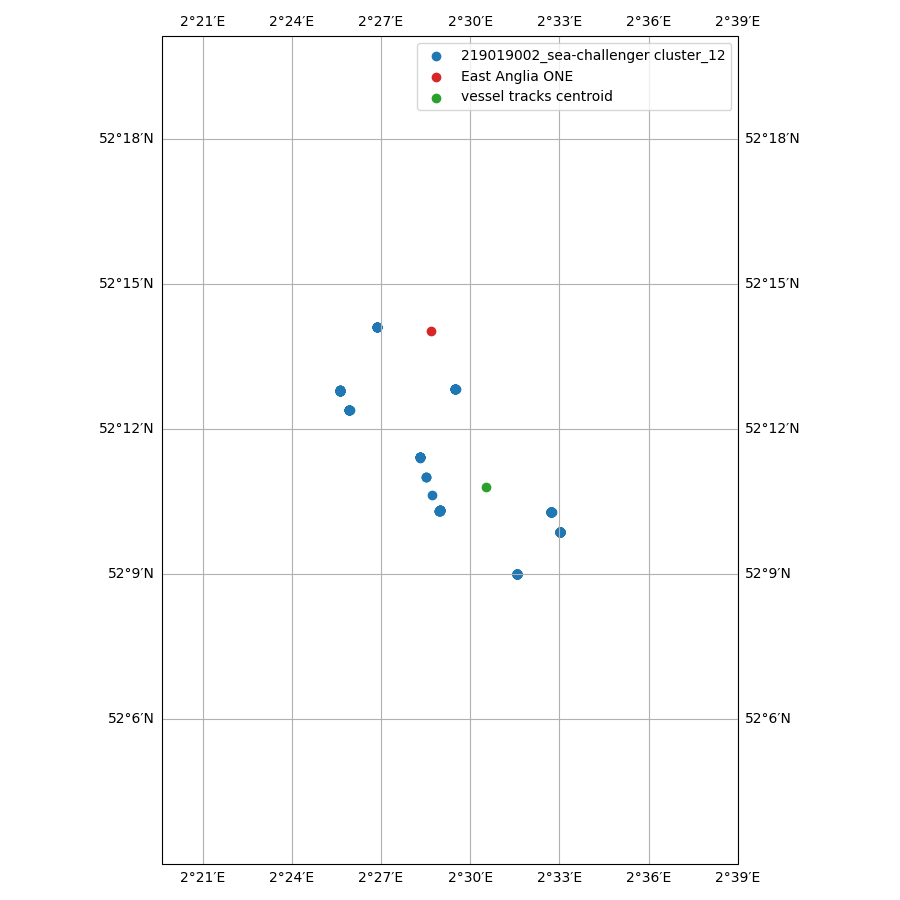

2.508617577702703 52.18012233108107


<IPython.core.display.Javascript object>


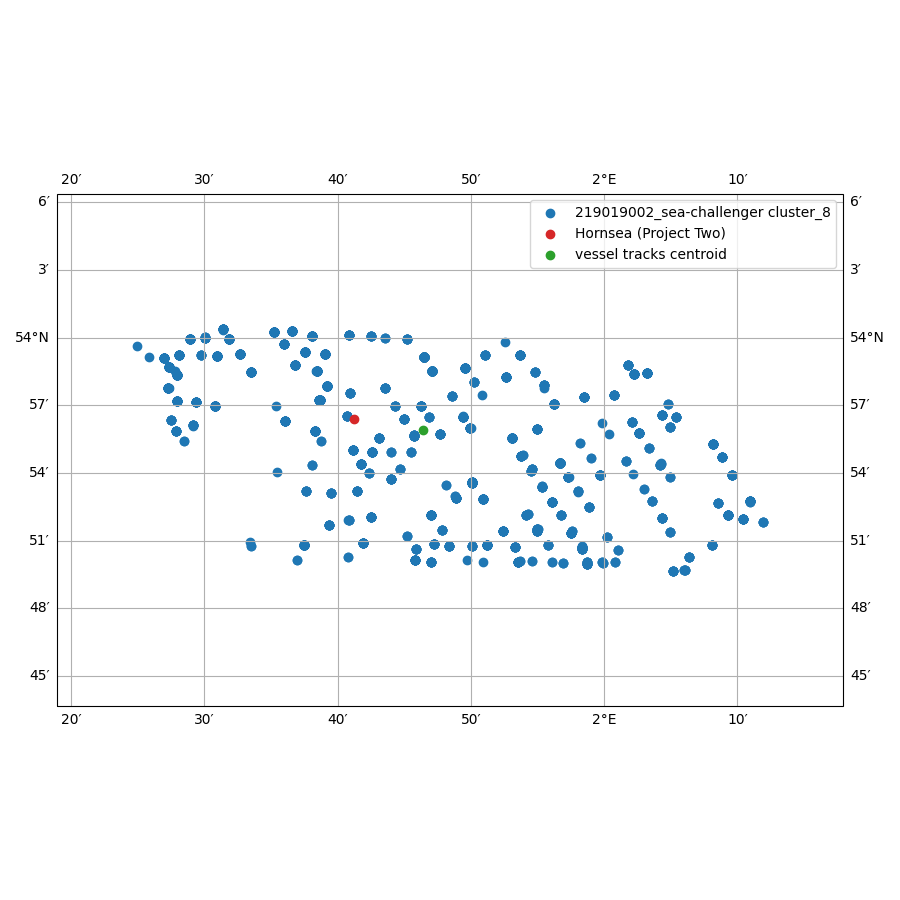

1.773028047594413 53.931872581479574


<IPython.core.display.Javascript object>


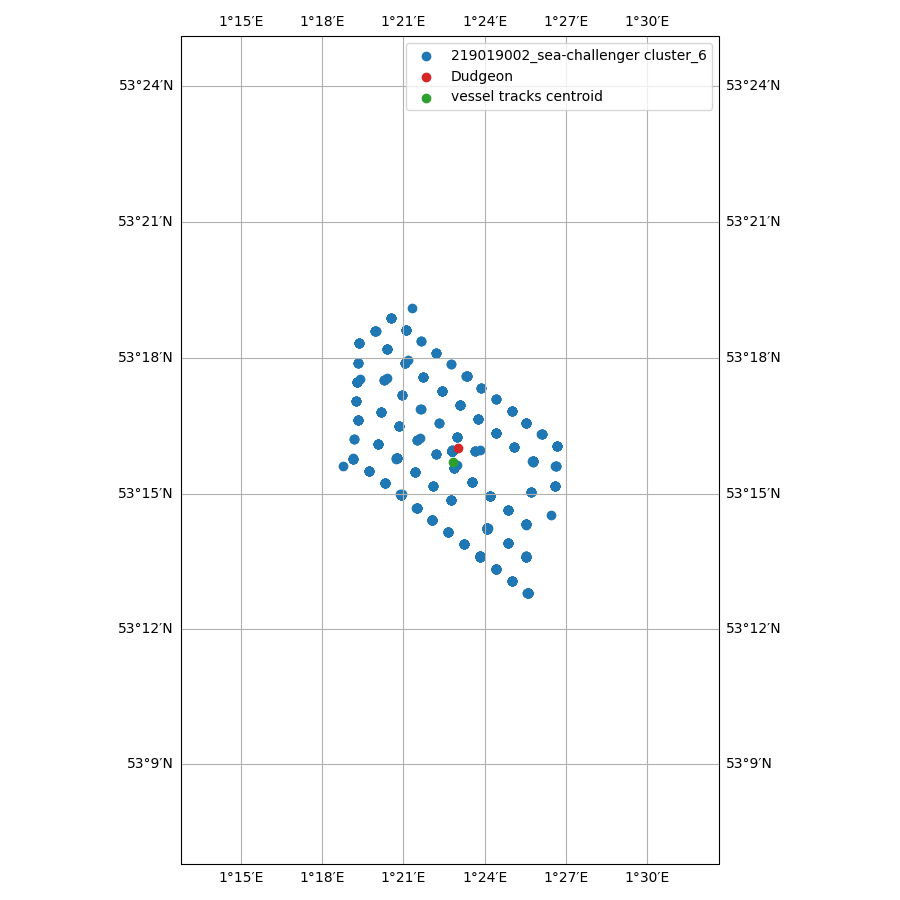

1.3804933311627907 53.261560604651166


<IPython.core.display.Javascript object>

14.12013025462963 54.78368041666667


<IPython.core.display.Javascript object>


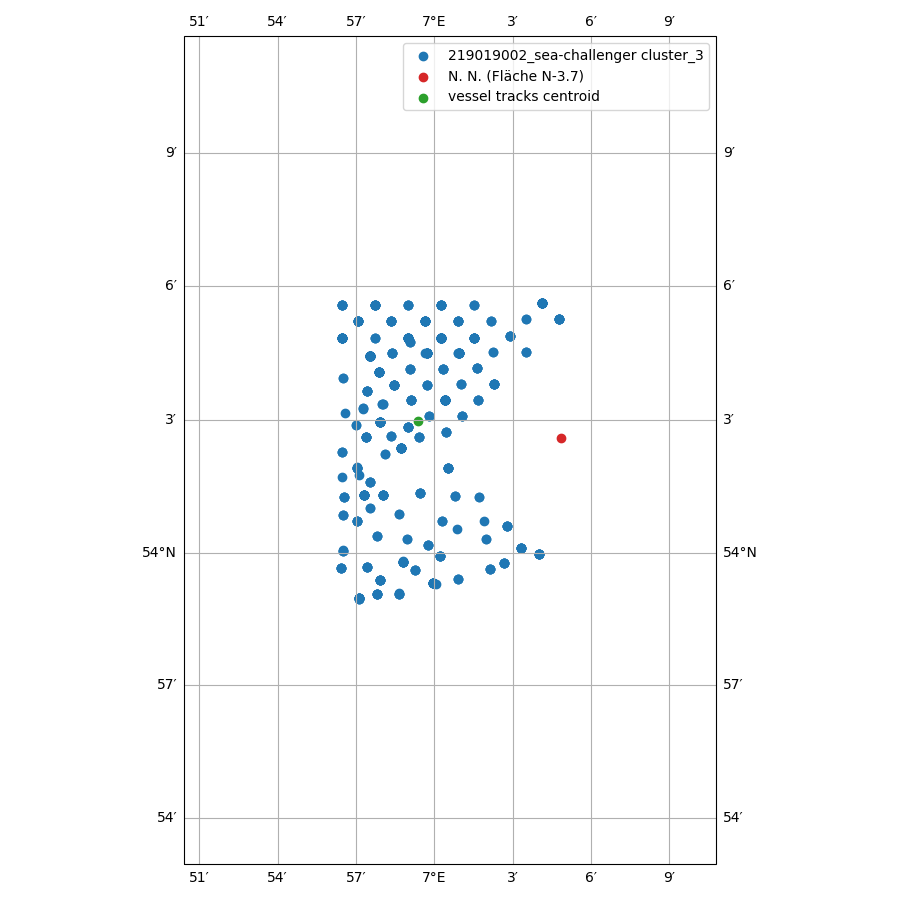

6.989922804920915 54.04942694200352


<IPython.core.display.Javascript object>


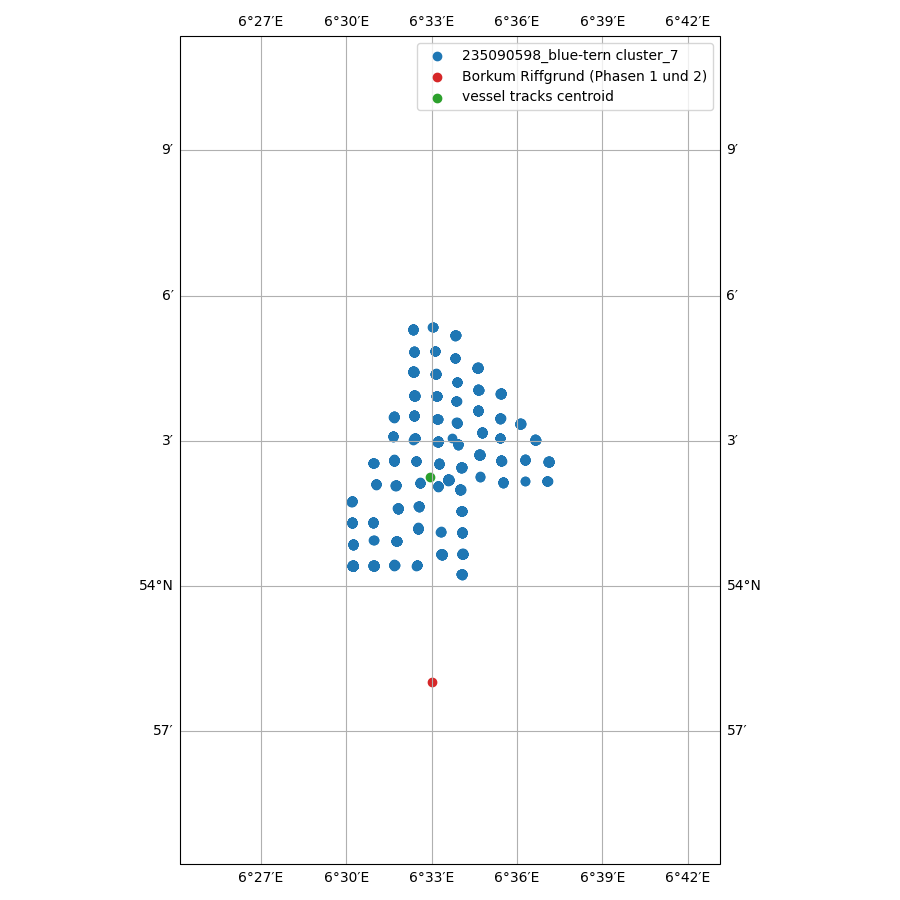

6.5492287037964125 54.03761958281185


<IPython.core.display.Javascript object>


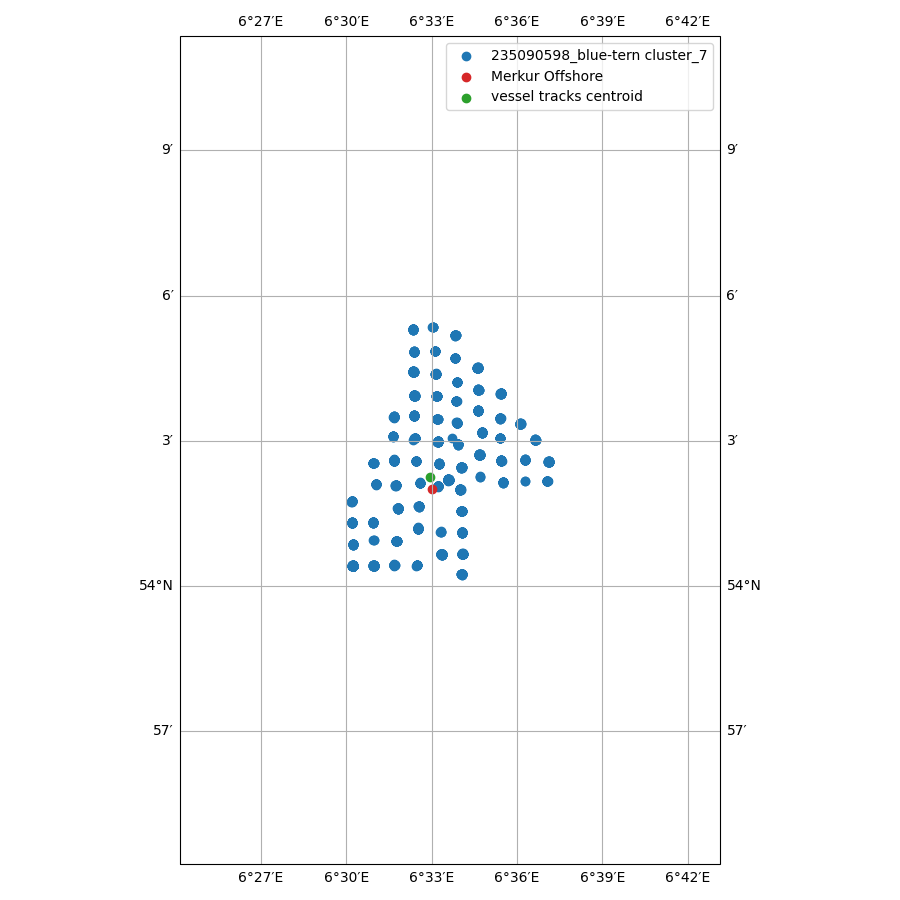

6.5492287037964125 54.03761958281185


<IPython.core.display.Javascript object>

6.5492287037964125 54.03761958281185


<IPython.core.display.Javascript object>


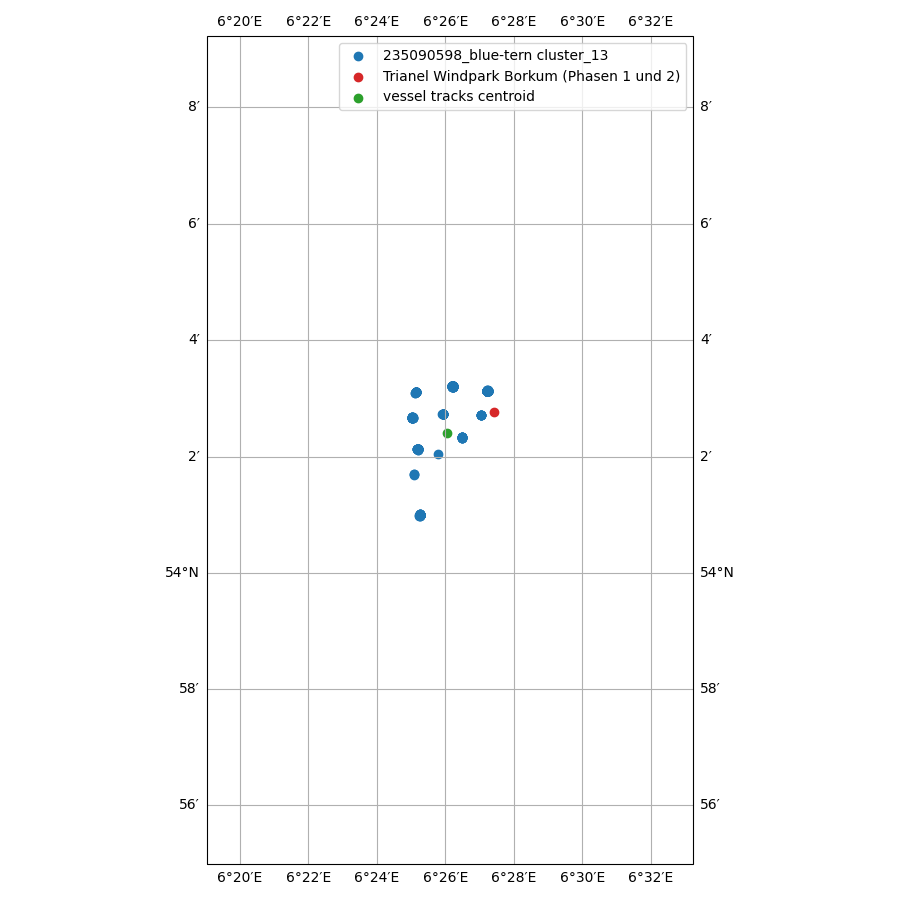

6.434286320205479 54.040182465753425


<IPython.core.display.Javascript object>


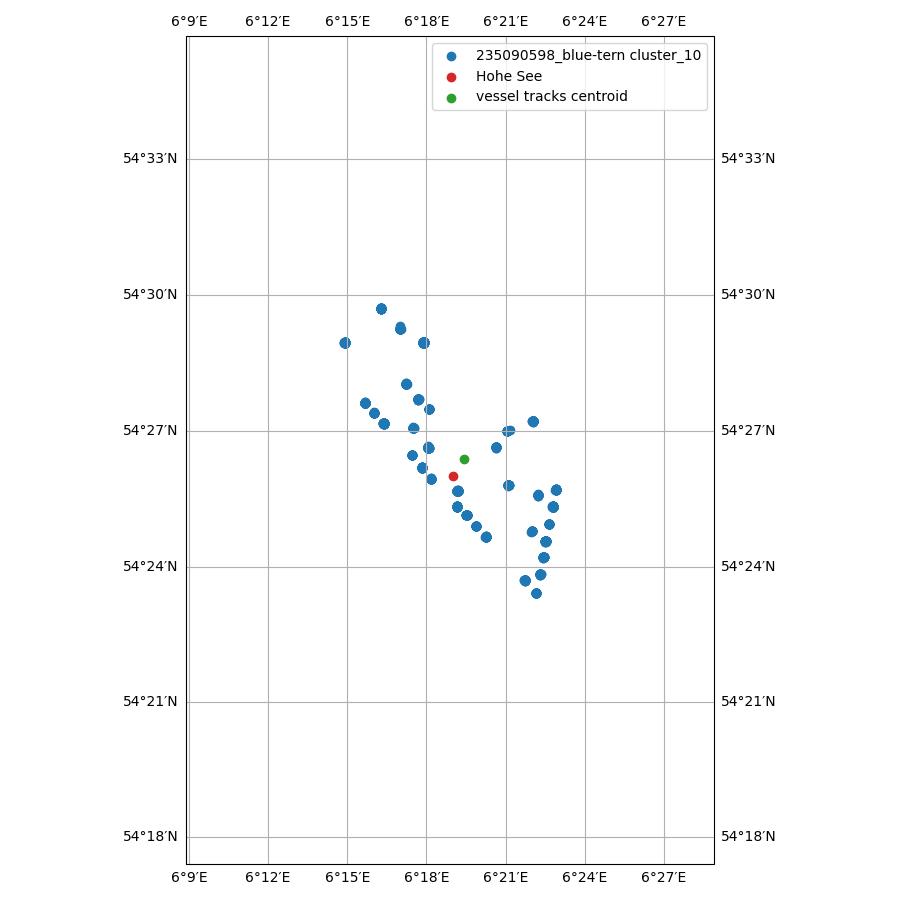

6.323666218259629 54.4394955064194


<IPython.core.display.Javascript object>


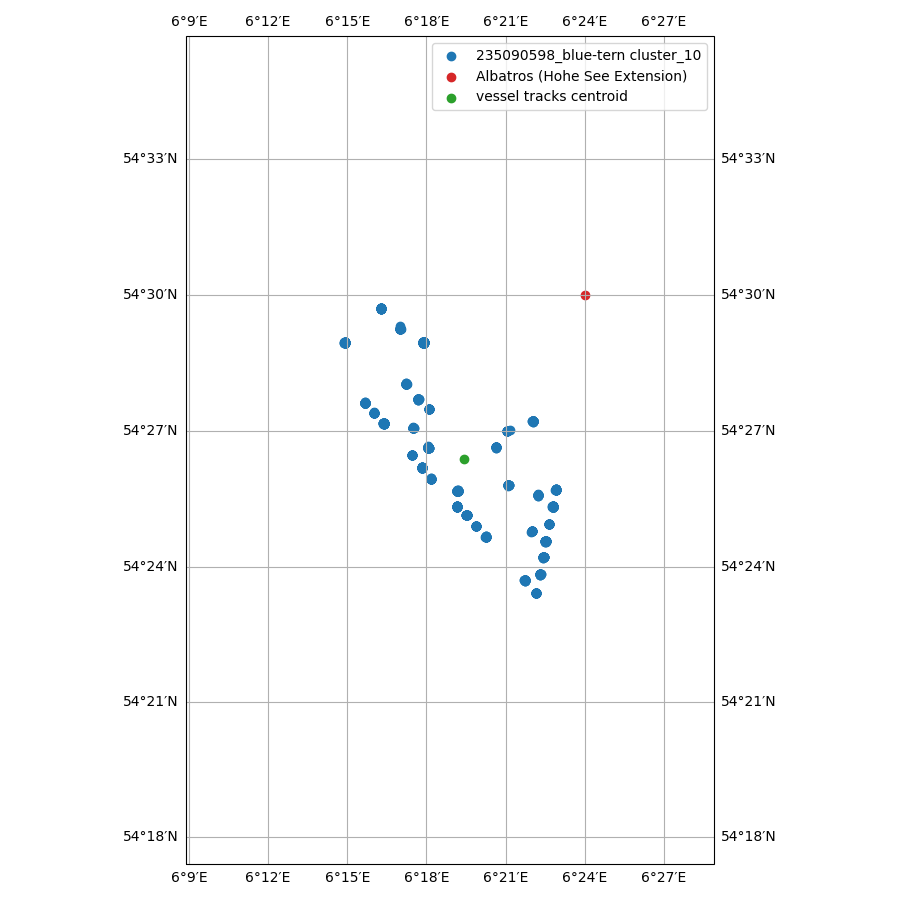

6.323666218259629 54.4394955064194


<IPython.core.display.Javascript object>

13.159989462151396 54.97231603585657


<IPython.core.display.Javascript object>

7.73415453015873 54.52070565079365


<IPython.core.display.Javascript object>


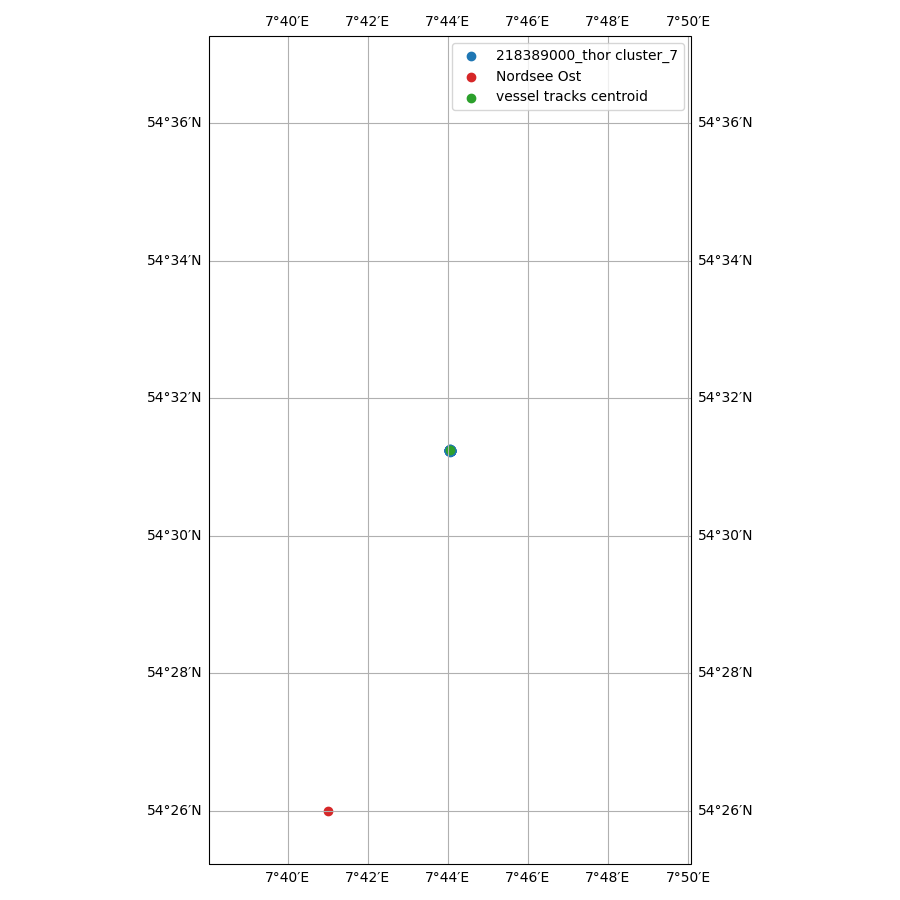

7.73415453015873 54.52070565079365


<IPython.core.display.Javascript object>


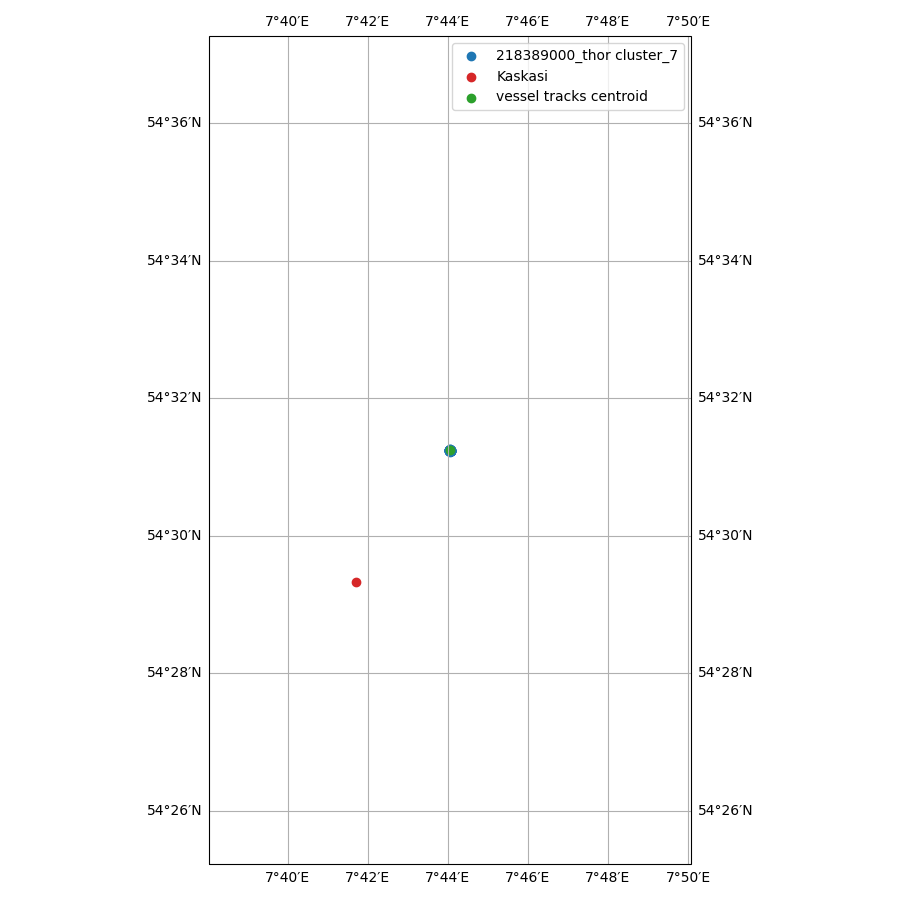

7.73415453015873 54.52070565079365


<IPython.core.display.Javascript object>


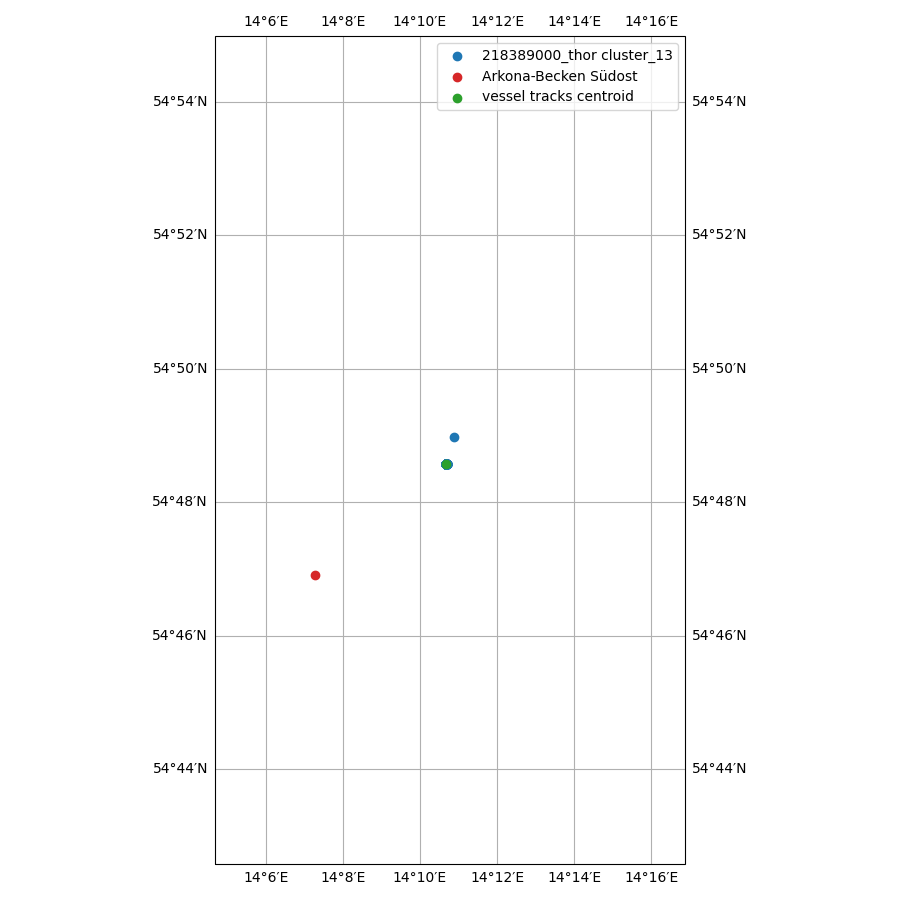

14.178088656575213 54.80960734153264


<IPython.core.display.Javascript object>


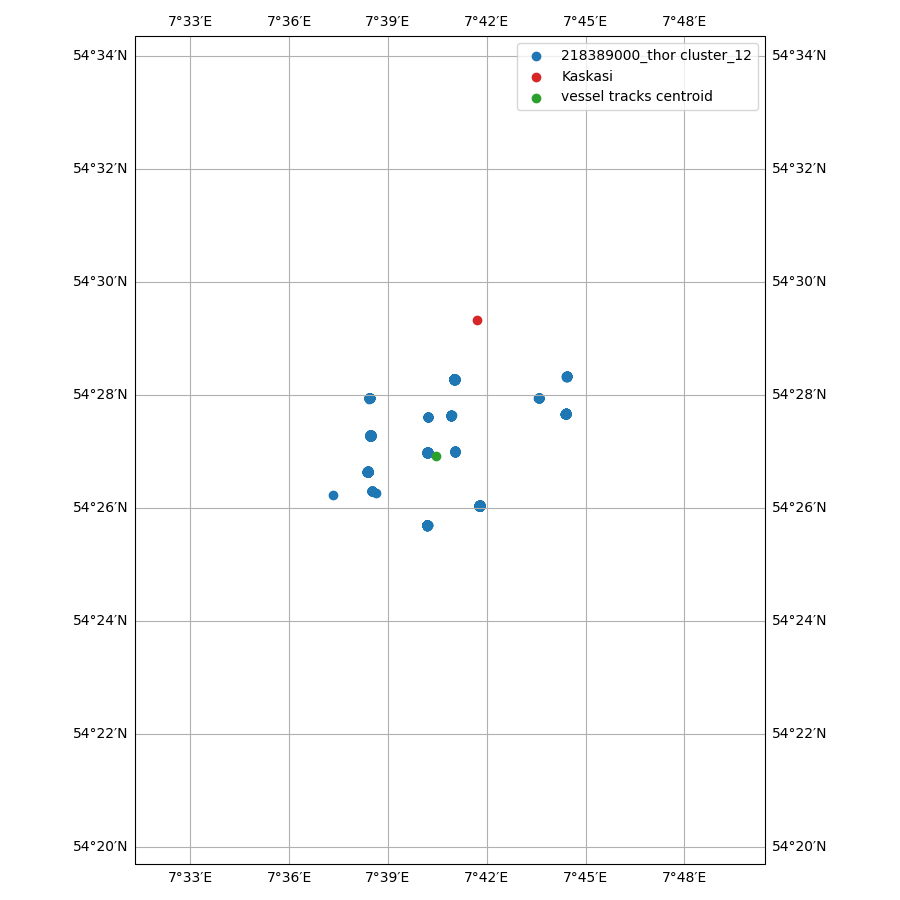

7.674543249858356 54.44886342776204


<IPython.core.display.Javascript object>


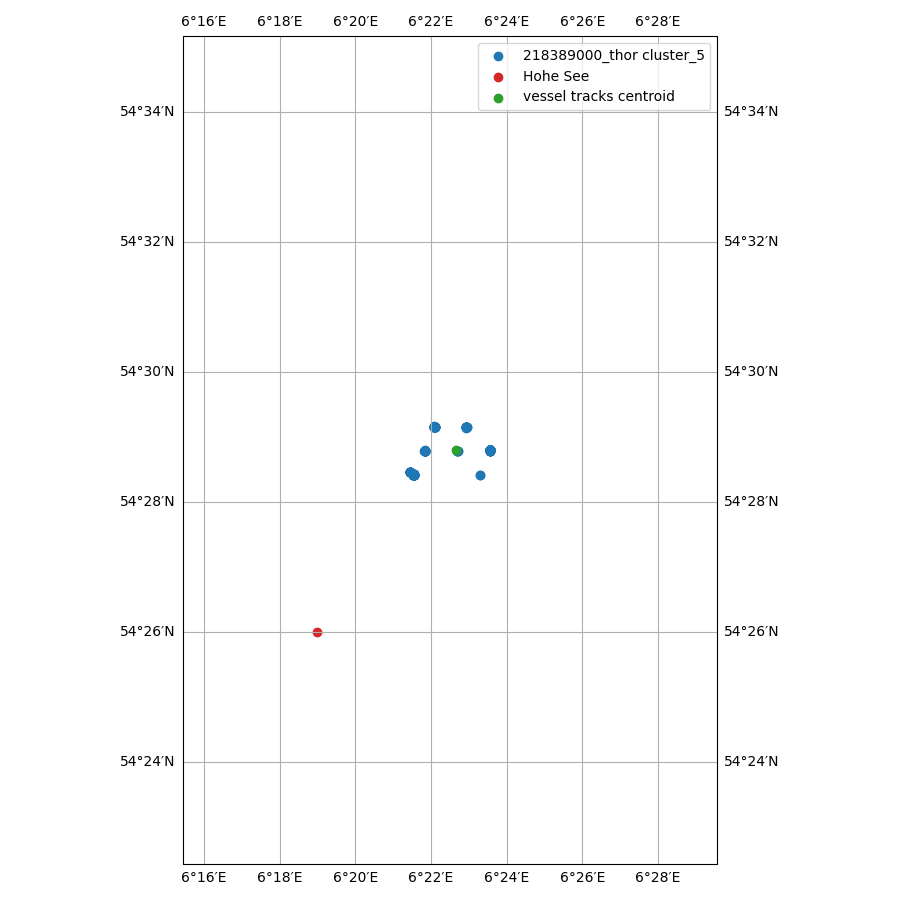

6.377868824884793 54.48003622119816


<IPython.core.display.Javascript object>


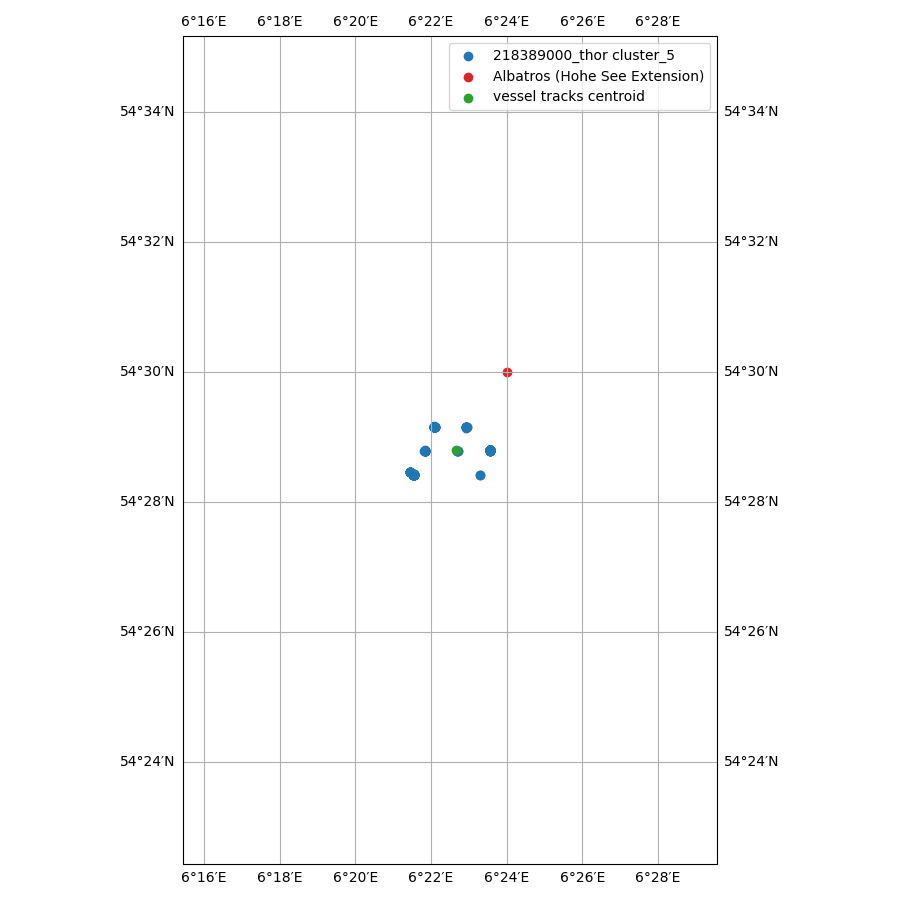

6.377868824884793 54.48003622119816


<IPython.core.display.Javascript object>

7.70029647933071 54.40005678149606


<IPython.core.display.Javascript object>


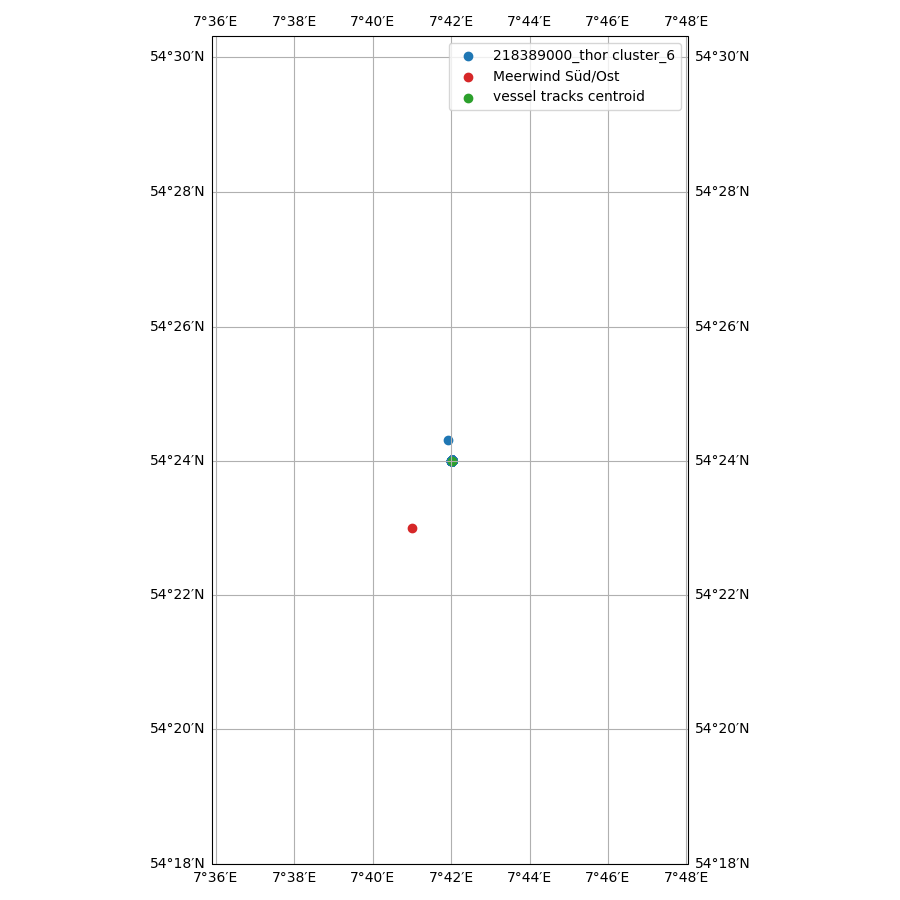

7.70029647933071 54.40005678149606


<IPython.core.display.Javascript object>


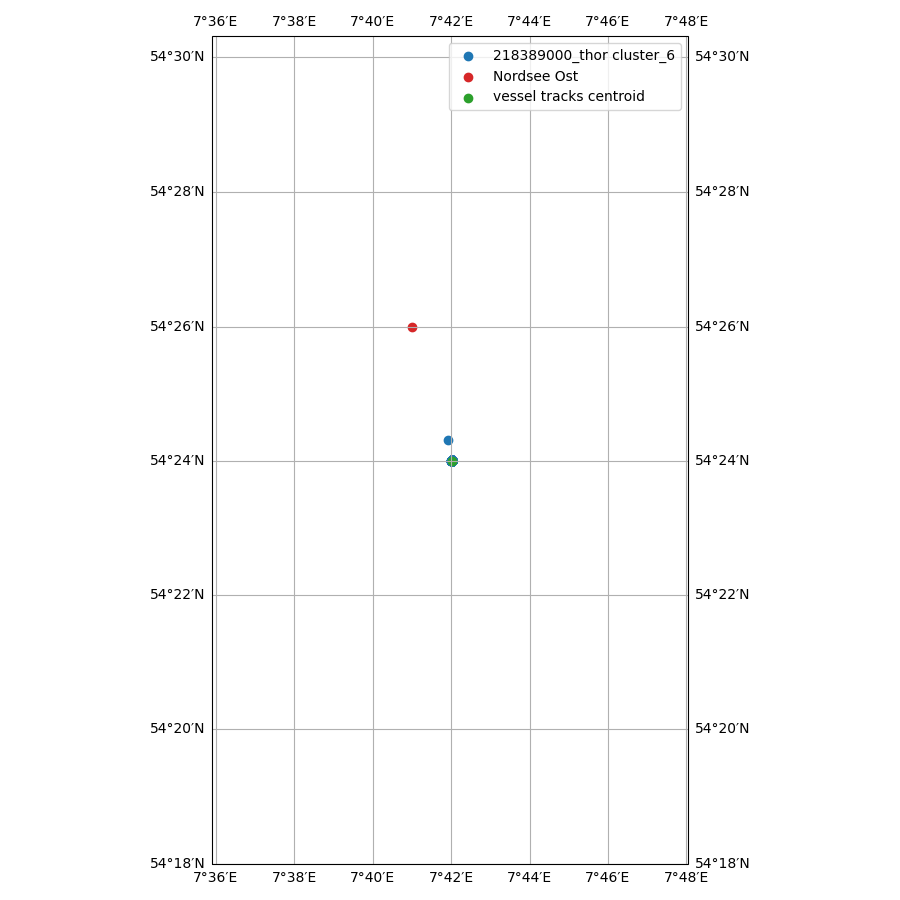

7.70029647933071 54.40005678149606


<IPython.core.display.Javascript object>


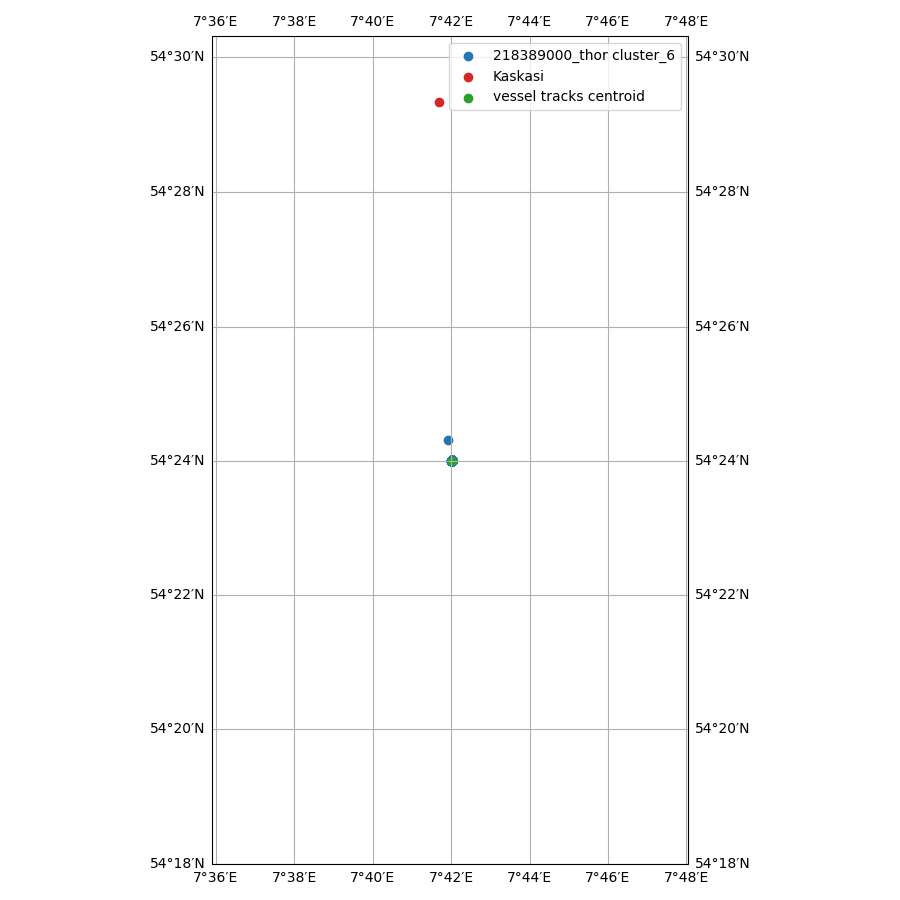

7.70029647933071 54.40005678149606


<IPython.core.display.Javascript object>


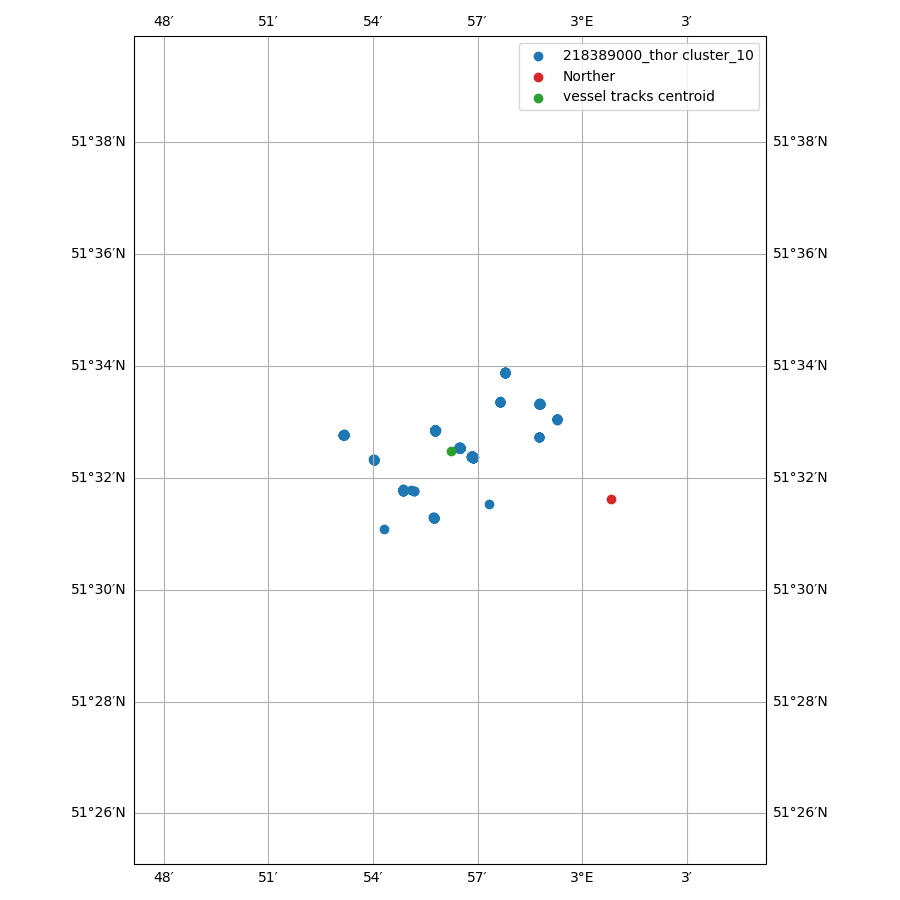

2.93736922734375 51.541419828125


<IPython.core.display.Javascript object>


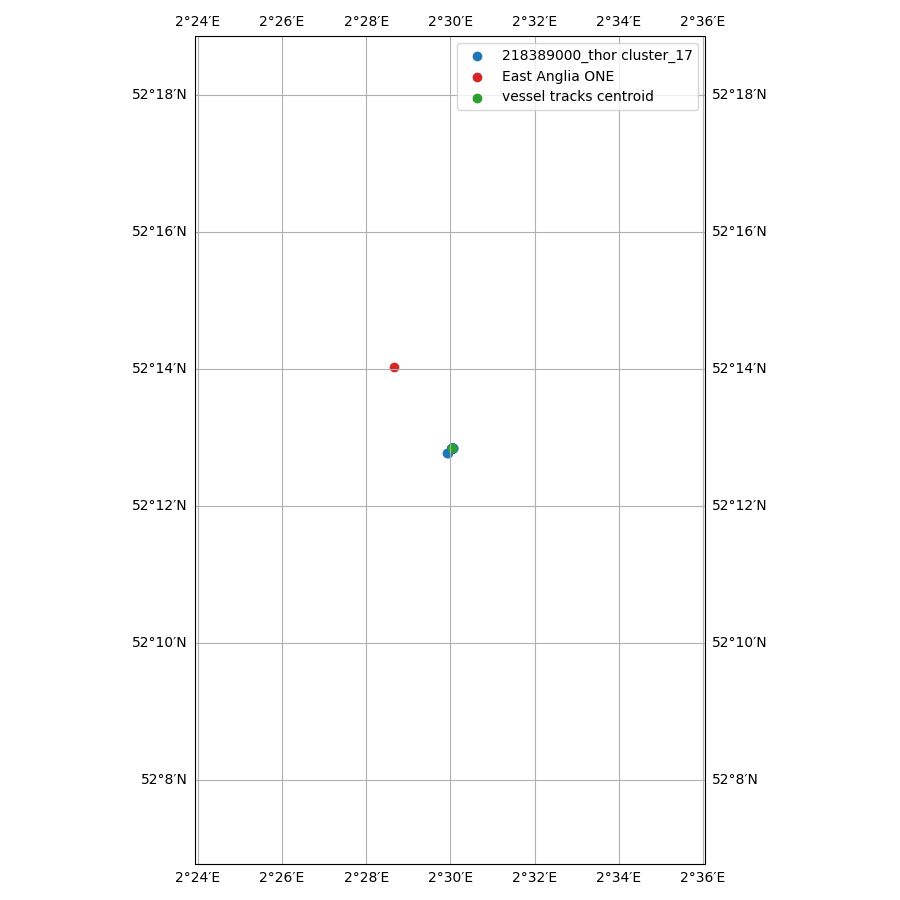

2.500724320557491 52.21420029616725


<IPython.core.display.Javascript object>


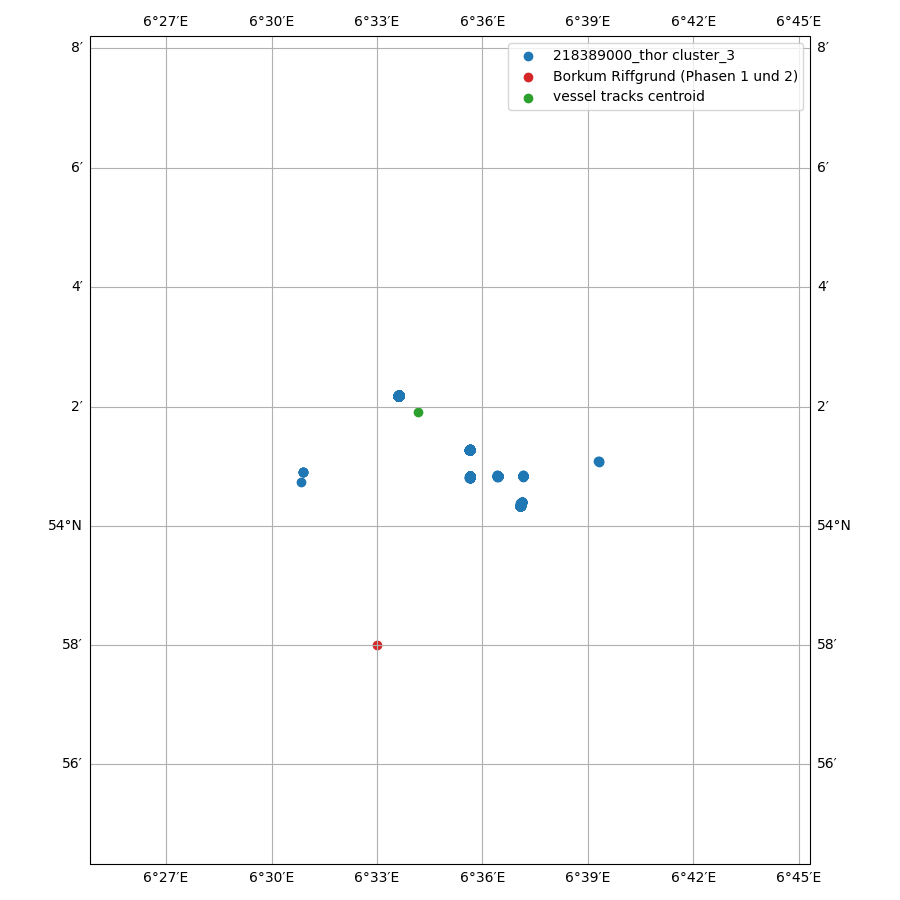

6.569447949462678 54.03170790589602


<IPython.core.display.Javascript object>


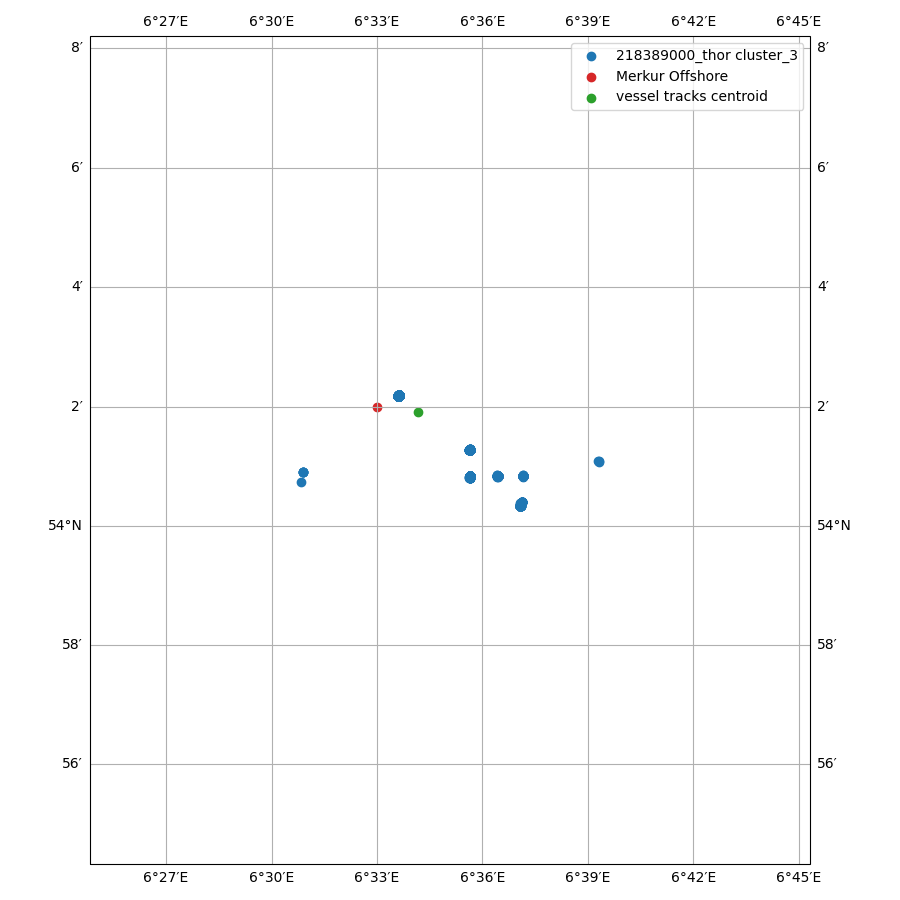

6.569447949462678 54.03170790589602


<IPython.core.display.Javascript object>


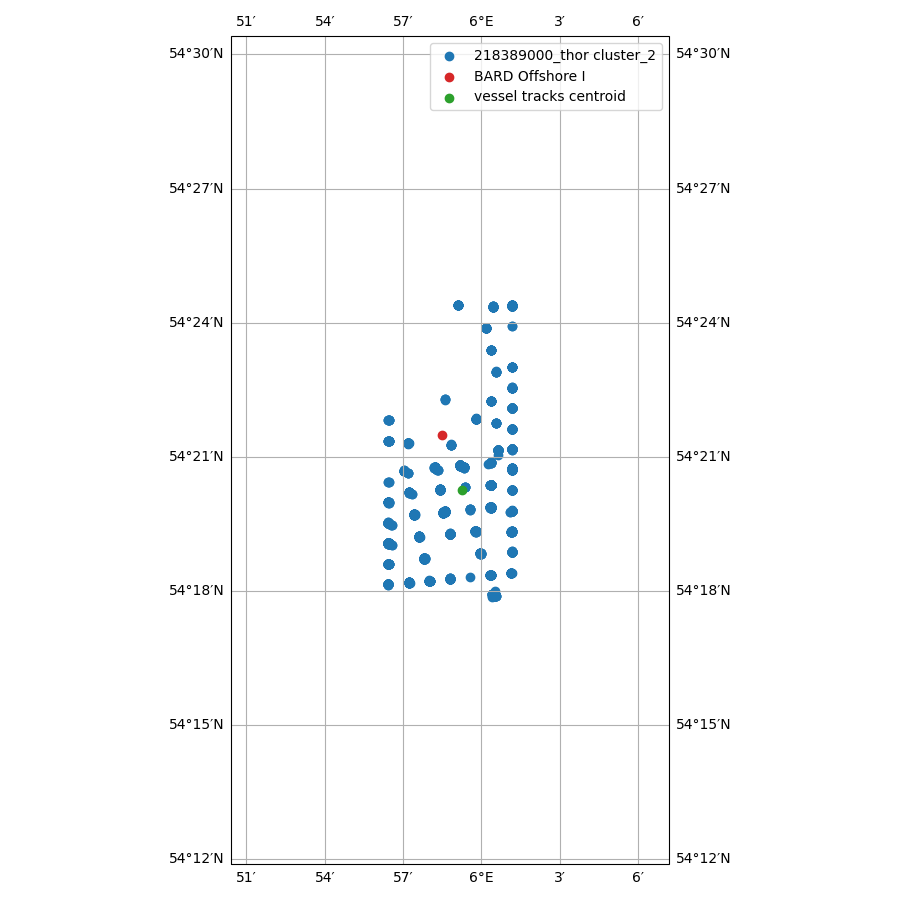

5.987476652653928 54.33760694267516


<IPython.core.display.Javascript object>


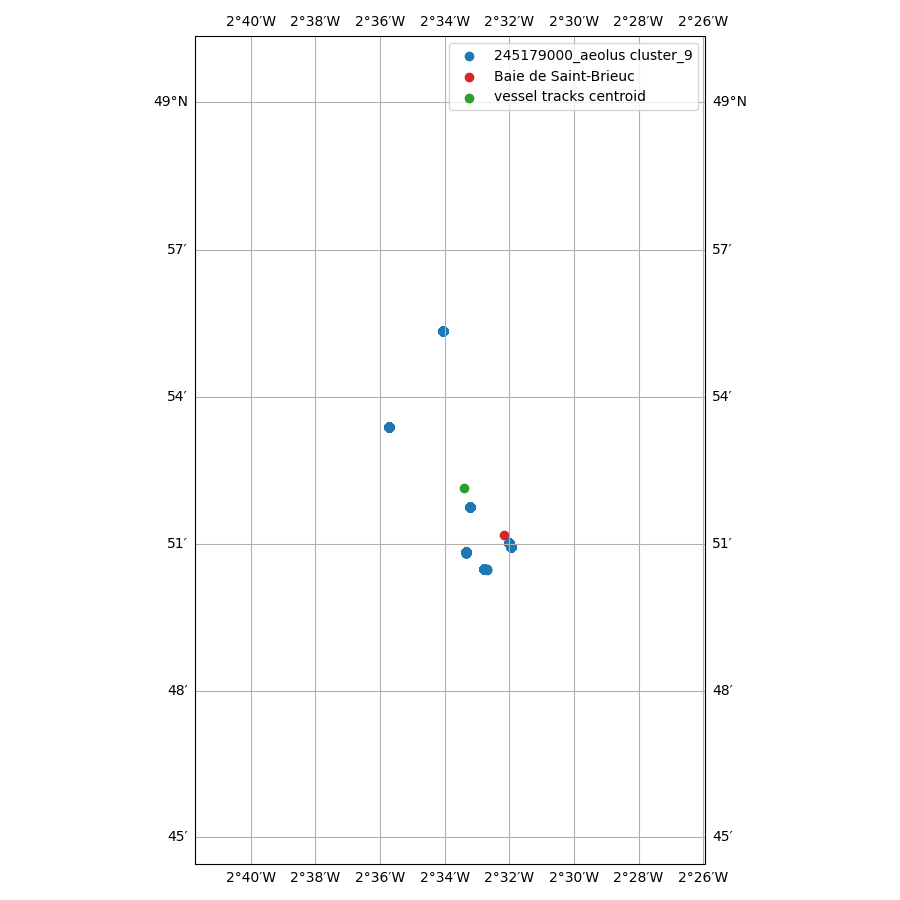

-2.556726715077605 48.86887309682188


<IPython.core.display.Javascript object>


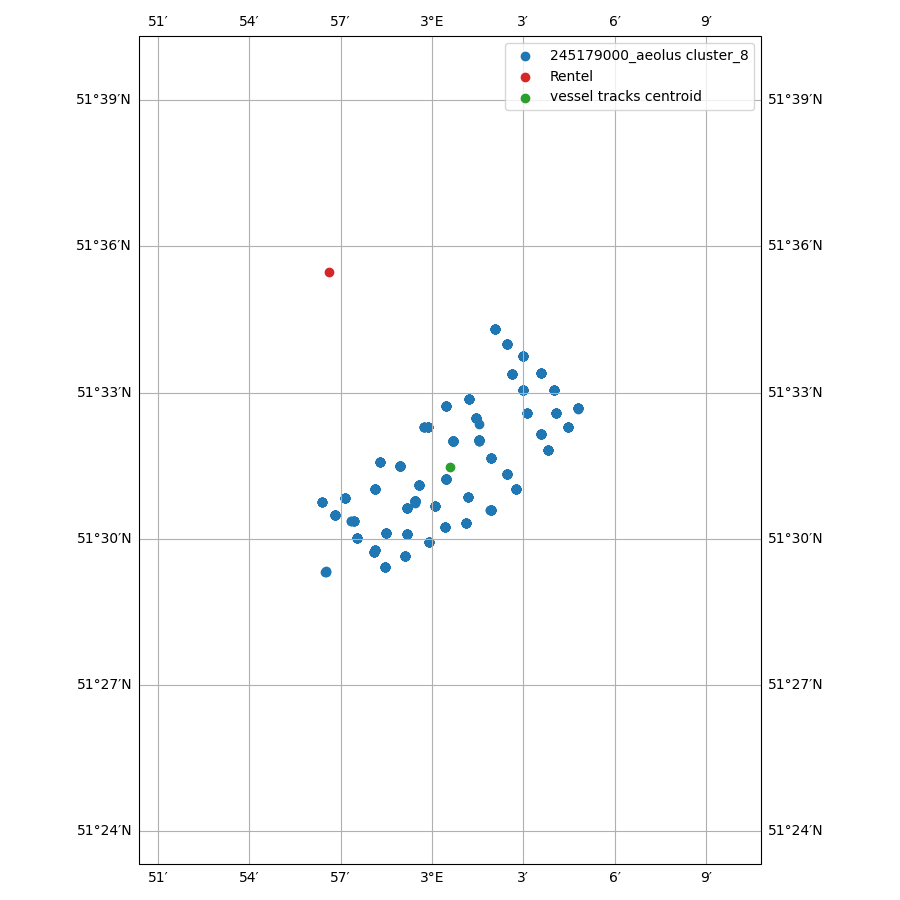

3.009912370098039 51.524634852941176


<IPython.core.display.Javascript object>


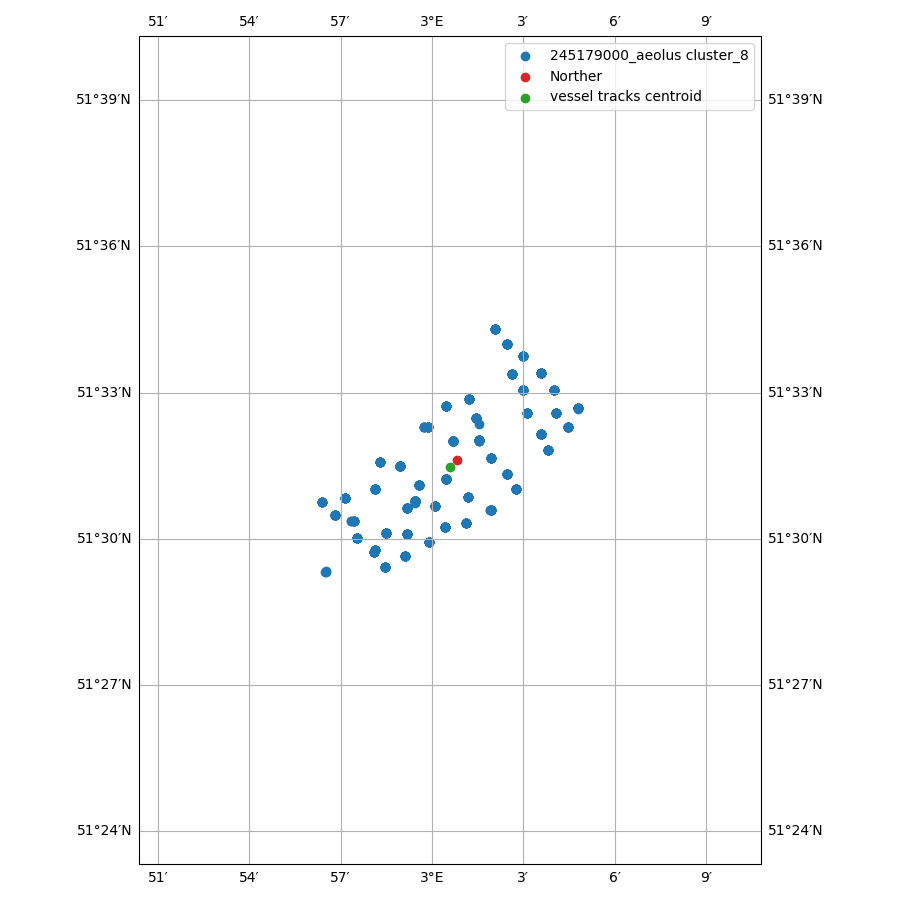

3.009912370098039 51.524634852941176


<IPython.core.display.Javascript object>


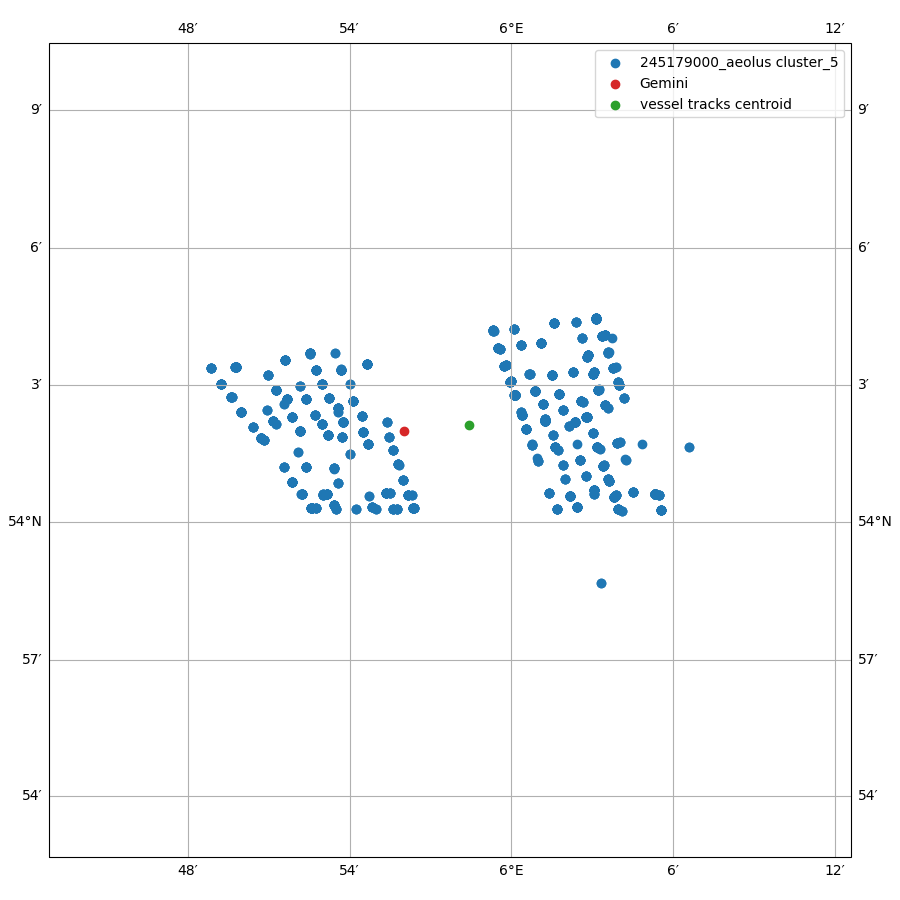

5.973997713690477 54.03551386904762


<IPython.core.display.Javascript object>


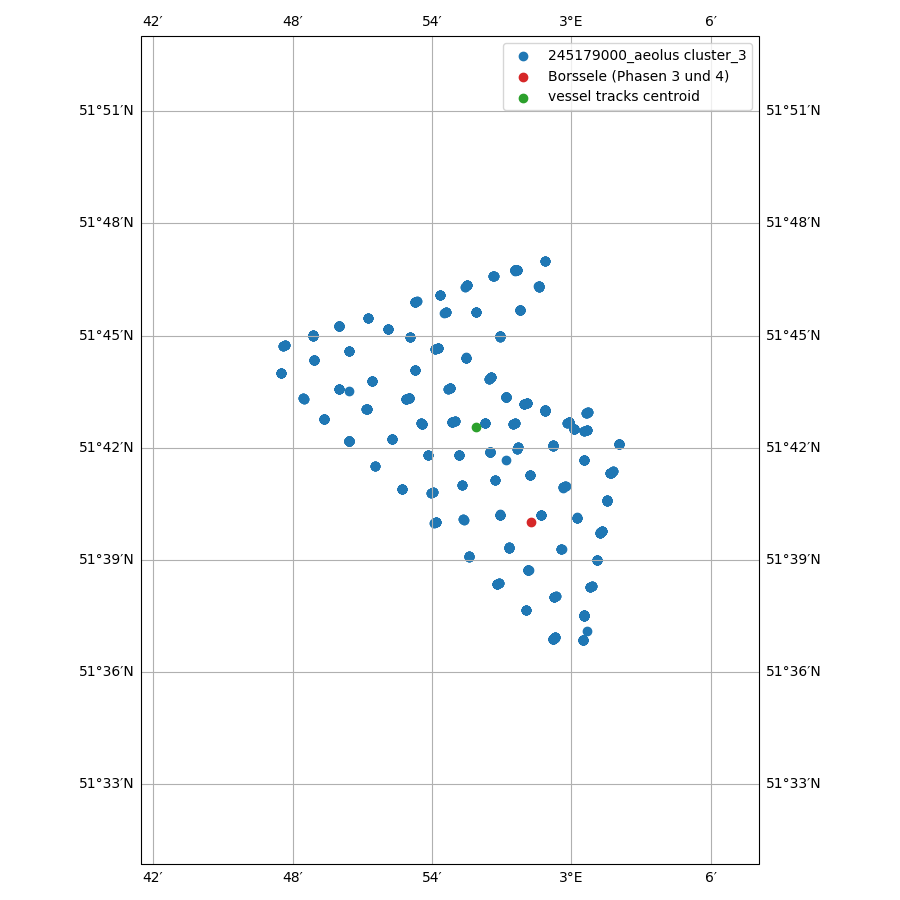

2.9317094823008847 51.70916120733249


<IPython.core.display.Javascript object>


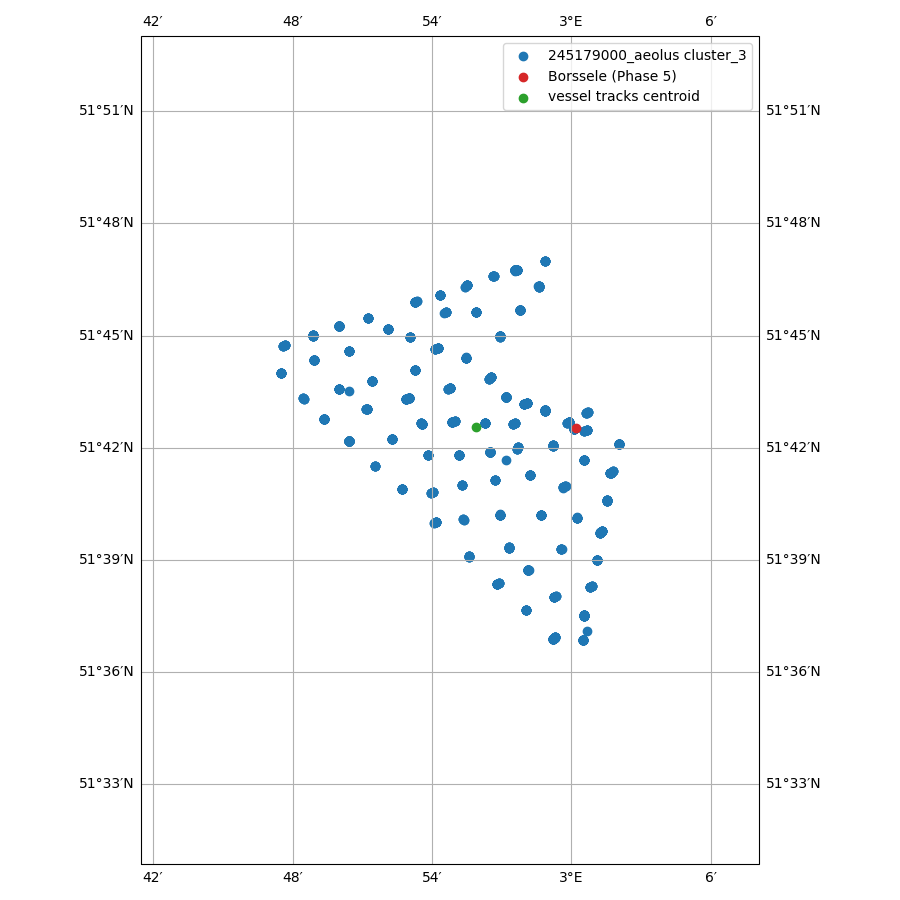

2.9317094823008847 51.70916120733249


<IPython.core.display.Javascript object>


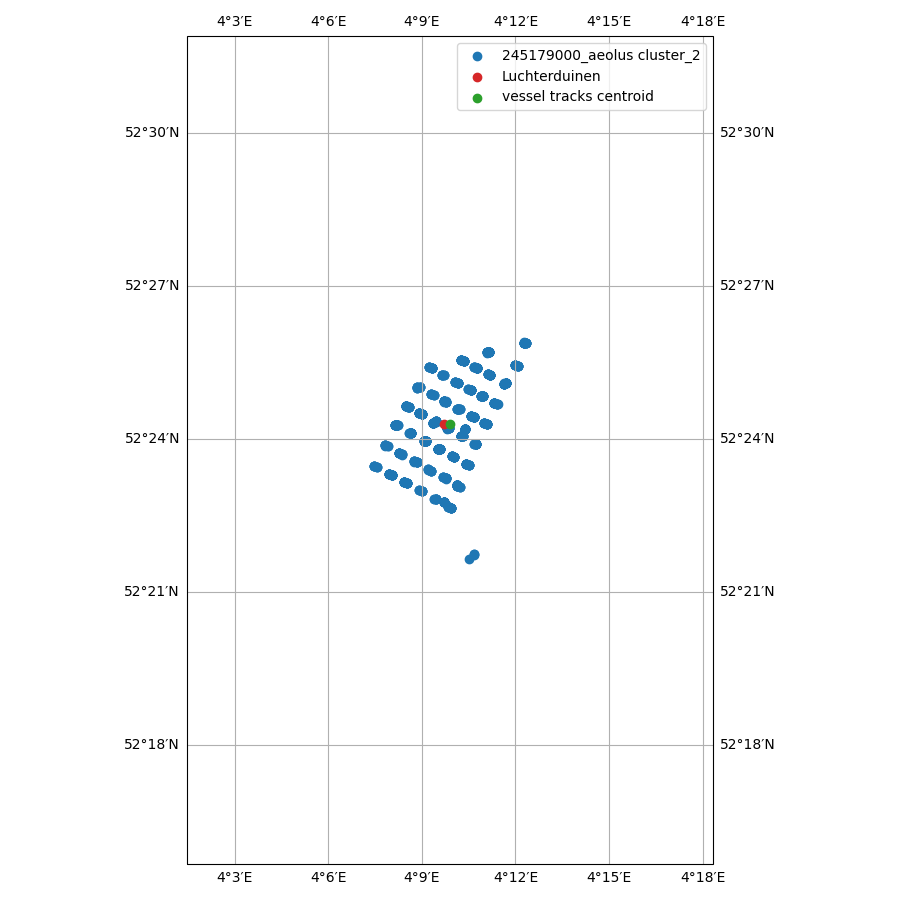

4.164911682539683 52.405141807081804


In [147]:
basedir = "../../data/marinetraffic/clustered/"
for _, matching_windfarm in matching_windfarms.iterrows():
    clusterpath = os.path.join(os.path.join(os.path.join(basedir, matching_windfarm.vesselname), matching_windfarm.clustername), f"{matching_windfarm.vesselname}_{matching_windfarm.clustername}.csv")
    if not os.path.isfile(clusterpath):
        print(f"no such file or directory: {clusterpath}")
    cluster = pd.read_csv(clusterpath)
    plot_cluster(cluster, windfarms.loc[matching_windfarm.windfarm_index], label=f'{matching_windfarm.vesselname} {matching_windfarm.clustername}', show_fig=True)